## FINGER TAPPING ANALYSIS
##### Data collected from patients with neurodegenerative disorders as well as healthy controls

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import time
import sys
from tqdm import tqdm
import os
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import math
from statsmodels.sandbox.stats.multicomp import multipletests
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model, model_from_yaml
from keras.constraints import max_norm
from keras.layers import Input, Conv1D, Flatten, Dropout, MaxPooling1D, Dense
from keras.layers import Activation, BatchNormalization, concatenate
from keras import optimizers
from keras.initializers import he_normal
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
%matplotlib inline

# from IPython.display import Audio
# sound_file = './sound/beep.wav'

C:\Users\Vladislava\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Read the data

train = scipy.io.loadmat('TrainData.mat')
val = scipy.io.loadmat('ValData.mat')


In [3]:
Xtrain, Ytrain = train['X'], train['Y']
Xval, Yval = val['X'], val['Y']

### Arite, lez make a model

In [4]:
def CNNModel(inputShape, nConvLayers, kernel_size):
    
    input1 = Input(shape = inputShape)

    #convolutions
    x = input1
    
    
    for i in range(0,nConvLayers):
        
        nFilters = 128 if i>1 else 32*(i+1)
        inside = 3 if i>1 else 2
        for temp in range(0,inside):
            x = Conv1D(filters = nFilters,
                  kernel_size = kernel_size,
                  padding = 'same',
                  strides = 1,
                  kernel_initializer = 'he_normal',
                  name = 'Conv1x5{}{}'.format(i,temp))(x)
            
            x = Activation('relu',name='ReLu{}{}'.format(i,temp))(x)
            x = BatchNormalization()(x)
            
        x = MaxPooling1D(2,
                      padding = 'same',
                      strides = 1,
                      name = 'MaxPooling1D{}'.format(i))(x)
    
    x = Dropout(0.5)(x)
    
    # Fully connected
    x = Flatten()(x)
    
    x = Dense(128,
              kernel_constraint = max_norm(3),
              kernel_initializer = 'he_normal')(x)
    x = Activation('relu', name = 'reLU_dense')(x)
    x = Dropout(0.6)(x)
    
    x = Dense(4)(x)
    x = Activation('softmax',name = 'Softmax')(x)

    m = Model(input1,x)
    return m


In [5]:
def saveModelTopology(model,modelName):
    model_json = model.to_yaml()
    with open(modelName+'.yaml', "w") as yaml_file:
        yaml_file.write(model_json)
    print("Saved model to {}.yaml".format(modelName))
    return


In [6]:
def defCallbacks(weightFile):
    
    checkpoint = ModelCheckpoint(weightFile,
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode='max')
    early = EarlyStopping(monitor='val_acc',
                          patience = 17,
                          verbose = 1,
                          mode='max')
#     def step_decay(epoch):
#         initial_lrate = 0.001
#         rate_drop = 0.25
#         nEpochs = 5
#         lrate = initial_lrate * math.pow(rate_drop, math.floor(epoch/nEpochs))
#         return lrate 
    
#     lrate = LearningRateScheduler(step_decay, verbose = 1)
    lr_plateau = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.2,
                                  patience = 6, min_lr = 0.0000000001,
                                  verbose = 1)
    
    return [checkpoint, early, lr_plateau]
    

In [7]:
def fitModel(model, modelName, Xtrain, Ytrain, Xval, Yval, epochs,batch_size):
    
    tic = time.time()
    
    # make file name
    tm = time.gmtime()
    weightFile = 'BEST_WEIGHTS{}.{}.{}.{}.{}.{}.h5'.format(modelName,tm[2],tm[1],tm[0],tm[3]+1,tm[4])
    
    #define callbacks
    callbacks = defCallbacks(weightFile)
    
    # FIT THE MODEL
    history = model.fit(x = Xtrain, y = Ytrain,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data = (Xval,Yval),
                        callbacks = callbacks)
    toc = time.time()
    print("Finished training in {} min ({} h)".format(round((toc-tic)/60,2),round((toc-tic)/3600,2)))

    
    # Save the weights
    #model.save_weights(str(modelName)+'.h5') # ???????
    
    return history

In [8]:
# def evaluateModel(model, modelName, Xval, Yval):
#     tic = time.time()
#     predictions = model.predict(Xval)
#     toc = time.time()
#     print('Finished prediction in: {} min'.format(round((toc-tic)/60,2)))

#     print('Evaluating...')
#     score = model.evaluate(Xval,Yval,verbose=1)
#     print(score)

#     #Save that stuff too pls.
#     tm = time.gmtime()    
#     predictionFile = 'Predictions-{}.{}.{}.{}.{}.{}.csv'.format(modelName,tm[2],tm[1],tm[0],tm[3]+1,tm[4])

#     dfPredicted = pd.DataFrame(predictions)
#     dfPredicted = dfPredicted.idxmax(axis =1)
#     dfExpected = pd.DataFrame(Yval)
#     dfExpected = dfExpected.idxmax(axis =1)
#     df = pd.DataFrame({'Predicted':dfPredicted, 'Expected':dfExpected})
#     df.to_csv(predictionFile,index = False)
#     print('Saved predictions to: ', predictionFile)
    
#     bingos = sum(df['Predicted'] ==df['Expected'])
#     accRly = 100*bingos/df.shape[0]
#     print('Currently your actual accuracy on Xval is: {}%'.format(round(accRly,2)))
    
#     return accRly

In [9]:
histories = []
#modelDepths = []
accuracies = []
nConvLayers = 5   
epochs = 200
batch_size = 16
kernelSizes = [9]

for kernel_size in kernelSizes:
    for i in range(2):
    
        model = CNNModel((Xtrain.shape[1],Xtrain.shape[2]),nConvLayers, kernel_size)
        opt = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
        model.compile(optimizer = opt,
                 loss='categorical_crossentropy',
                 metrics = ['accuracy'])
        #model.summary()

        modelName = 'CNN'+str(batch_size)+'Batch'+ str(nConvLayers)+'KERNEL'+str(kernel_size)
        #saveModelTopology(model,modelName)
        model.save(modelName+'CEO.h5')

        print('TRAINING...')

        history = fitModel(model,modelName, Xtrain, Ytrain, Xval, Yval, epochs,batch_size)
        histories.append(history.history)   
        #modelDepths.append(nConvLayers)
        
        



    
#     acc = evaluateModel(model, modelName, Xval, Yval)
#     accuracies.append(acc)
    
    
#     with open("hist.txt", "w") as f:
#         for h in histories:
#             f.write(str(h) +"\n")

#     with open("hist.txt", "r") as f:
#         for line in f:
#             histo.append(int(line.strip()))

TRAINING...
Train on 2323 samples, validate on 318 samples
Epoch 1/200
2323/2323 [==============================] - ETA: 11:46 - loss: 4.0540 - acc: 0.18 - ETA: 6:16 - loss: 3.6563 - acc: 0.2188 - ETA: 4:24 - loss: 3.5693 - acc: 0.187 - ETA: 3:28 - loss: 3.5024 - acc: 0.250 - ETA: 2:55 - loss: 3.4206 - acc: 0.275 - ETA: 2:32 - loss: 3.4703 - acc: 0.291 - ETA: 2:16 - loss: 3.4845 - acc: 0.258 - ETA: 2:04 - loss: 3.3177 - acc: 0.273 - ETA: 1:54 - loss: 3.2008 - acc: 0.277 - ETA: 1:47 - loss: 3.1824 - acc: 0.281 - ETA: 1:40 - loss: 3.1506 - acc: 0.284 - ETA: 1:35 - loss: 3.0662 - acc: 0.307 - ETA: 1:30 - loss: 3.0198 - acc: 0.293 - ETA: 1:26 - loss: 2.9479 - acc: 0.308 - ETA: 1:23 - loss: 2.9421 - acc: 0.304 - ETA: 1:20 - loss: 2.9290 - acc: 0.312 - ETA: 1:17 - loss: 3.0059 - acc: 0.308 - ETA: 1:14 - loss: 2.9814 - acc: 0.316 - ETA: 1:12 - loss: 2.8888 - acc: 0.325 - ETA: 1:10 - loss: 2.8639 - acc: 0.328 - ETA: 1:08 - loss: 2.8104 - acc: 0.336 - ETA: 1:06 - loss: 2.7806 - acc: 0.332 - ETA

2323/2323 [==============================] - ETA: 53s - loss: 1.2764 - acc: 0.56 - ETA: 51s - loss: 1.2352 - acc: 0.50 - ETA: 49s - loss: 1.2108 - acc: 0.50 - ETA: 48s - loss: 1.2219 - acc: 0.46 - ETA: 47s - loss: 1.2663 - acc: 0.42 - ETA: 47s - loss: 1.2779 - acc: 0.41 - ETA: 46s - loss: 1.2730 - acc: 0.40 - ETA: 46s - loss: 1.2944 - acc: 0.39 - ETA: 46s - loss: 1.3296 - acc: 0.40 - ETA: 45s - loss: 1.2972 - acc: 0.42 - ETA: 45s - loss: 1.2886 - acc: 0.42 - ETA: 44s - loss: 1.3003 - acc: 0.42 - ETA: 44s - loss: 1.3024 - acc: 0.41 - ETA: 44s - loss: 1.3031 - acc: 0.41 - ETA: 43s - loss: 1.2959 - acc: 0.42 - ETA: 43s - loss: 1.2999 - acc: 0.41 - ETA: 43s - loss: 1.3048 - acc: 0.40 - ETA: 42s - loss: 1.3140 - acc: 0.40 - ETA: 42s - loss: 1.3118 - acc: 0.39 - ETA: 42s - loss: 1.3169 - acc: 0.39 - ETA: 41s - loss: 1.3235 - acc: 0.38 - ETA: 41s - loss: 1.3136 - acc: 0.39 - ETA: 40s - loss: 1.3132 - acc: 0.40 - ETA: 40s - loss: 1.2916 - acc: 0.41 - ETA: 40s - loss: 1.2899 - acc: 0.41 - ETA: 

2323/2323 [==============================] - ETA: 52s - loss: 0.9378 - acc: 0.68 - ETA: 50s - loss: 1.0652 - acc: 0.59 - ETA: 49s - loss: 0.9885 - acc: 0.62 - ETA: 48s - loss: 1.0244 - acc: 0.62 - ETA: 47s - loss: 1.0029 - acc: 0.62 - ETA: 47s - loss: 1.0544 - acc: 0.60 - ETA: 47s - loss: 1.0505 - acc: 0.60 - ETA: 46s - loss: 1.0295 - acc: 0.60 - ETA: 46s - loss: 1.0303 - acc: 0.59 - ETA: 45s - loss: 1.0111 - acc: 0.60 - ETA: 45s - loss: 1.0124 - acc: 0.59 - ETA: 45s - loss: 1.0468 - acc: 0.57 - ETA: 44s - loss: 1.0641 - acc: 0.55 - ETA: 44s - loss: 1.0672 - acc: 0.55 - ETA: 44s - loss: 1.0833 - acc: 0.55 - ETA: 43s - loss: 1.0968 - acc: 0.54 - ETA: 43s - loss: 1.0950 - acc: 0.55 - ETA: 42s - loss: 1.0870 - acc: 0.55 - ETA: 42s - loss: 1.0878 - acc: 0.54 - ETA: 42s - loss: 1.0826 - acc: 0.55 - ETA: 41s - loss: 1.0843 - acc: 0.54 - ETA: 41s - loss: 1.0811 - acc: 0.54 - ETA: 41s - loss: 1.0836 - acc: 0.53 - ETA: 40s - loss: 1.0786 - acc: 0.53 - ETA: 40s - loss: 1.0943 - acc: 0.54 - ETA: 

2323/2323 [==============================] - ETA: 54s - loss: 0.6767 - acc: 0.62 - ETA: 50s - loss: 0.7516 - acc: 0.62 - ETA: 49s - loss: 0.8168 - acc: 0.54 - ETA: 48s - loss: 0.8579 - acc: 0.56 - ETA: 48s - loss: 0.8749 - acc: 0.53 - ETA: 47s - loss: 0.9114 - acc: 0.53 - ETA: 47s - loss: 0.9165 - acc: 0.55 - ETA: 46s - loss: 0.9094 - acc: 0.56 - ETA: 46s - loss: 0.9296 - acc: 0.54 - ETA: 45s - loss: 0.8985 - acc: 0.56 - ETA: 45s - loss: 0.9019 - acc: 0.57 - ETA: 45s - loss: 0.8748 - acc: 0.58 - ETA: 44s - loss: 0.8574 - acc: 0.60 - ETA: 44s - loss: 0.8744 - acc: 0.59 - ETA: 44s - loss: 0.8663 - acc: 0.60 - ETA: 43s - loss: 0.8699 - acc: 0.59 - ETA: 43s - loss: 0.8728 - acc: 0.59 - ETA: 43s - loss: 0.8711 - acc: 0.60 - ETA: 42s - loss: 0.8768 - acc: 0.59 - ETA: 42s - loss: 0.8913 - acc: 0.60 - ETA: 42s - loss: 0.8879 - acc: 0.60 - ETA: 41s - loss: 0.8891 - acc: 0.60 - ETA: 41s - loss: 0.8929 - acc: 0.59 - ETA: 41s - loss: 0.8966 - acc: 0.59 - ETA: 40s - loss: 0.8925 - acc: 0.59 - ETA: 

2323/2323 [==============================] - ETA: 54s - loss: 0.4287 - acc: 0.93 - ETA: 50s - loss: 0.4968 - acc: 0.87 - ETA: 49s - loss: 0.5340 - acc: 0.81 - ETA: 48s - loss: 0.7275 - acc: 0.75 - ETA: 48s - loss: 0.6737 - acc: 0.78 - ETA: 47s - loss: 0.6527 - acc: 0.78 - ETA: 47s - loss: 0.6751 - acc: 0.75 - ETA: 46s - loss: 0.6863 - acc: 0.74 - ETA: 46s - loss: 0.7220 - acc: 0.73 - ETA: 46s - loss: 0.6869 - acc: 0.75 - ETA: 45s - loss: 0.7002 - acc: 0.75 - ETA: 45s - loss: 0.6877 - acc: 0.75 - ETA: 45s - loss: 0.6926 - acc: 0.75 - ETA: 44s - loss: 0.6862 - acc: 0.75 - ETA: 44s - loss: 0.6801 - acc: 0.75 - ETA: 44s - loss: 0.6794 - acc: 0.75 - ETA: 43s - loss: 0.6644 - acc: 0.76 - ETA: 43s - loss: 0.6824 - acc: 0.76 - ETA: 43s - loss: 0.6890 - acc: 0.75 - ETA: 42s - loss: 0.6781 - acc: 0.75 - ETA: 42s - loss: 0.6814 - acc: 0.75 - ETA: 41s - loss: 0.6890 - acc: 0.75 - ETA: 41s - loss: 0.6904 - acc: 0.75 - ETA: 41s - loss: 0.6883 - acc: 0.75 - ETA: 40s - loss: 0.6853 - acc: 0.75 - ETA: 

2323/2323 [==============================] - ETA: 52s - loss: 0.4124 - acc: 0.81 - ETA: 49s - loss: 0.5399 - acc: 0.75 - ETA: 48s - loss: 0.6542 - acc: 0.70 - ETA: 48s - loss: 0.6340 - acc: 0.73 - ETA: 47s - loss: 0.6499 - acc: 0.71 - ETA: 47s - loss: 0.6023 - acc: 0.73 - ETA: 46s - loss: 0.5895 - acc: 0.75 - ETA: 46s - loss: 0.5712 - acc: 0.76 - ETA: 46s - loss: 0.5775 - acc: 0.77 - ETA: 45s - loss: 0.5666 - acc: 0.78 - ETA: 45s - loss: 0.5700 - acc: 0.76 - ETA: 45s - loss: 0.5574 - acc: 0.77 - ETA: 44s - loss: 0.5617 - acc: 0.76 - ETA: 44s - loss: 0.5659 - acc: 0.76 - ETA: 43s - loss: 0.5866 - acc: 0.75 - ETA: 43s - loss: 0.5692 - acc: 0.76 - ETA: 43s - loss: 0.5636 - acc: 0.76 - ETA: 42s - loss: 0.5483 - acc: 0.77 - ETA: 42s - loss: 0.5540 - acc: 0.76 - ETA: 42s - loss: 0.5402 - acc: 0.77 - ETA: 41s - loss: 0.5443 - acc: 0.77 - ETA: 41s - loss: 0.5467 - acc: 0.77 - ETA: 41s - loss: 0.5394 - acc: 0.77 - ETA: 40s - loss: 0.5367 - acc: 0.78 - ETA: 40s - loss: 0.5395 - acc: 0.78 - ETA: 

2323/2323 [==============================] - ETA: 53s - loss: 0.6583 - acc: 0.81 - ETA: 50s - loss: 0.4194 - acc: 0.87 - ETA: 49s - loss: 0.3553 - acc: 0.91 - ETA: 48s - loss: 0.3677 - acc: 0.90 - ETA: 48s - loss: 0.3184 - acc: 0.92 - ETA: 47s - loss: 0.3447 - acc: 0.91 - ETA: 47s - loss: 0.3642 - acc: 0.90 - ETA: 46s - loss: 0.3853 - acc: 0.89 - ETA: 46s - loss: 0.4473 - acc: 0.86 - ETA: 46s - loss: 0.4756 - acc: 0.85 - ETA: 45s - loss: 0.4456 - acc: 0.86 - ETA: 45s - loss: 0.4320 - acc: 0.87 - ETA: 45s - loss: 0.4302 - acc: 0.87 - ETA: 44s - loss: 0.4370 - acc: 0.86 - ETA: 44s - loss: 0.4451 - acc: 0.85 - ETA: 43s - loss: 0.4424 - acc: 0.85 - ETA: 43s - loss: 0.4394 - acc: 0.85 - ETA: 43s - loss: 0.4314 - acc: 0.85 - ETA: 42s - loss: 0.4358 - acc: 0.84 - ETA: 42s - loss: 0.4291 - acc: 0.85 - ETA: 42s - loss: 0.4232 - acc: 0.85 - ETA: 41s - loss: 0.4088 - acc: 0.86 - ETA: 41s - loss: 0.4167 - acc: 0.85 - ETA: 41s - loss: 0.4130 - acc: 0.85 - ETA: 40s - loss: 0.4035 - acc: 0.86 - ETA: 

2323/2323 [==============================] - ETA: 53s - loss: 0.1801 - acc: 0.87 - ETA: 50s - loss: 0.1523 - acc: 0.90 - ETA: 49s - loss: 0.2621 - acc: 0.89 - ETA: 48s - loss: 0.2316 - acc: 0.90 - ETA: 48s - loss: 0.2786 - acc: 0.91 - ETA: 47s - loss: 0.2721 - acc: 0.90 - ETA: 47s - loss: 0.2508 - acc: 0.91 - ETA: 46s - loss: 0.2846 - acc: 0.91 - ETA: 46s - loss: 0.2774 - acc: 0.90 - ETA: 46s - loss: 0.2777 - acc: 0.90 - ETA: 45s - loss: 0.2643 - acc: 0.90 - ETA: 45s - loss: 0.2729 - acc: 0.91 - ETA: 45s - loss: 0.2615 - acc: 0.91 - ETA: 44s - loss: 0.2520 - acc: 0.92 - ETA: 44s - loss: 0.2597 - acc: 0.91 - ETA: 43s - loss: 0.2572 - acc: 0.91 - ETA: 43s - loss: 0.2611 - acc: 0.90 - ETA: 43s - loss: 0.2505 - acc: 0.91 - ETA: 42s - loss: 0.2466 - acc: 0.91 - ETA: 42s - loss: 0.2387 - acc: 0.92 - ETA: 42s - loss: 0.2484 - acc: 0.91 - ETA: 41s - loss: 0.2461 - acc: 0.92 - ETA: 41s - loss: 0.2592 - acc: 0.92 - ETA: 41s - loss: 0.2623 - acc: 0.92 - ETA: 40s - loss: 0.2692 - acc: 0.91 - ETA: 

2323/2323 [==============================] - ETA: 51s - loss: 0.0807 - acc: 1.00 - ETA: 49s - loss: 0.1945 - acc: 0.93 - ETA: 48s - loss: 0.1968 - acc: 0.93 - ETA: 48s - loss: 0.1819 - acc: 0.95 - ETA: 47s - loss: 0.1880 - acc: 0.95 - ETA: 47s - loss: 0.2133 - acc: 0.92 - ETA: 47s - loss: 0.2101 - acc: 0.91 - ETA: 46s - loss: 0.1975 - acc: 0.92 - ETA: 46s - loss: 0.1864 - acc: 0.93 - ETA: 46s - loss: 0.2147 - acc: 0.91 - ETA: 45s - loss: 0.2064 - acc: 0.92 - ETA: 45s - loss: 0.2141 - acc: 0.91 - ETA: 45s - loss: 0.2167 - acc: 0.91 - ETA: 44s - loss: 0.2054 - acc: 0.92 - ETA: 44s - loss: 0.2120 - acc: 0.92 - ETA: 44s - loss: 0.2026 - acc: 0.92 - ETA: 43s - loss: 0.2031 - acc: 0.92 - ETA: 43s - loss: 0.2055 - acc: 0.92 - ETA: 42s - loss: 0.2073 - acc: 0.92 - ETA: 42s - loss: 0.1990 - acc: 0.92 - ETA: 42s - loss: 0.1981 - acc: 0.92 - ETA: 41s - loss: 0.2002 - acc: 0.92 - ETA: 41s - loss: 0.1942 - acc: 0.92 - ETA: 41s - loss: 0.1886 - acc: 0.92 - ETA: 40s - loss: 0.1913 - acc: 0.93 - ETA: 

2323/2323 [==============================] - ETA: 48s - loss: 0.1350 - acc: 0.93 - ETA: 47s - loss: 0.0989 - acc: 0.96 - ETA: 47s - loss: 0.1156 - acc: 0.95 - ETA: 47s - loss: 0.1332 - acc: 0.93 - ETA: 47s - loss: 0.1364 - acc: 0.93 - ETA: 47s - loss: 0.1174 - acc: 0.94 - ETA: 46s - loss: 0.1113 - acc: 0.94 - ETA: 46s - loss: 0.1295 - acc: 0.94 - ETA: 46s - loss: 0.1419 - acc: 0.93 - ETA: 45s - loss: 0.1520 - acc: 0.92 - ETA: 45s - loss: 0.1429 - acc: 0.93 - ETA: 45s - loss: 0.1407 - acc: 0.93 - ETA: 44s - loss: 0.1445 - acc: 0.93 - ETA: 44s - loss: 0.1354 - acc: 0.93 - ETA: 44s - loss: 0.1745 - acc: 0.92 - ETA: 43s - loss: 0.1728 - acc: 0.91 - ETA: 43s - loss: 0.1647 - acc: 0.92 - ETA: 43s - loss: 0.1673 - acc: 0.92 - ETA: 42s - loss: 0.1840 - acc: 0.92 - ETA: 42s - loss: 0.1794 - acc: 0.92 - ETA: 42s - loss: 0.1809 - acc: 0.92 - ETA: 41s - loss: 0.1768 - acc: 0.92 - ETA: 41s - loss: 0.1750 - acc: 0.92 - ETA: 41s - loss: 0.1744 - acc: 0.92 - ETA: 40s - loss: 0.1687 - acc: 0.93 - ETA: 

2323/2323 [==============================] - ETA: 53s - loss: 0.0311 - acc: 1.00 - ETA: 50s - loss: 0.0808 - acc: 0.96 - ETA: 49s - loss: 0.1287 - acc: 0.95 - ETA: 49s - loss: 0.1595 - acc: 0.93 - ETA: 48s - loss: 0.1394 - acc: 0.95 - ETA: 47s - loss: 0.1282 - acc: 0.95 - ETA: 47s - loss: 0.1198 - acc: 0.96 - ETA: 46s - loss: 0.1266 - acc: 0.96 - ETA: 46s - loss: 0.1188 - acc: 0.96 - ETA: 46s - loss: 0.1135 - acc: 0.96 - ETA: 45s - loss: 0.1233 - acc: 0.96 - ETA: 45s - loss: 0.1163 - acc: 0.96 - ETA: 45s - loss: 0.1182 - acc: 0.95 - ETA: 44s - loss: 0.1261 - acc: 0.95 - ETA: 44s - loss: 0.1302 - acc: 0.95 - ETA: 44s - loss: 0.1301 - acc: 0.95 - ETA: 43s - loss: 0.1243 - acc: 0.95 - ETA: 43s - loss: 0.1254 - acc: 0.95 - ETA: 43s - loss: 0.1208 - acc: 0.95 - ETA: 42s - loss: 0.1188 - acc: 0.95 - ETA: 42s - loss: 0.1151 - acc: 0.96 - ETA: 41s - loss: 0.1120 - acc: 0.96 - ETA: 41s - loss: 0.1090 - acc: 0.96 - ETA: 41s - loss: 0.1148 - acc: 0.96 - ETA: 40s - loss: 0.1227 - acc: 0.95 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0118 - acc: 1.00 - ETA: 47s - loss: 0.0092 - acc: 1.00 - ETA: 47s - loss: 0.0157 - acc: 1.00 - ETA: 47s - loss: 0.0299 - acc: 1.00 - ETA: 47s - loss: 0.0317 - acc: 1.00 - ETA: 46s - loss: 0.0311 - acc: 1.00 - ETA: 46s - loss: 0.0368 - acc: 0.99 - ETA: 46s - loss: 0.0354 - acc: 0.99 - ETA: 45s - loss: 0.0362 - acc: 0.99 - ETA: 45s - loss: 0.0388 - acc: 0.98 - ETA: 45s - loss: 0.0372 - acc: 0.98 - ETA: 44s - loss: 0.0381 - acc: 0.98 - ETA: 44s - loss: 0.0369 - acc: 0.99 - ETA: 44s - loss: 0.0369 - acc: 0.99 - ETA: 43s - loss: 0.0383 - acc: 0.99 - ETA: 43s - loss: 0.0478 - acc: 0.98 - ETA: 43s - loss: 0.0475 - acc: 0.98 - ETA: 43s - loss: 0.0452 - acc: 0.98 - ETA: 42s - loss: 0.0470 - acc: 0.98 - ETA: 42s - loss: 0.0525 - acc: 0.98 - ETA: 42s - loss: 0.0527 - acc: 0.98 - ETA: 41s - loss: 0.0559 - acc: 0.98 - ETA: 41s - loss: 0.0589 - acc: 0.98 - ETA: 41s - loss: 0.0566 - acc: 0.98 - ETA: 40s - loss: 0.0567 - acc: 0.98 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.2047 - acc: 0.93 - ETA: 47s - loss: 0.1103 - acc: 0.96 - ETA: 47s - loss: 0.0762 - acc: 0.97 - ETA: 47s - loss: 0.0879 - acc: 0.96 - ETA: 47s - loss: 0.0721 - acc: 0.97 - ETA: 46s - loss: 0.0647 - acc: 0.97 - ETA: 46s - loss: 0.0592 - acc: 0.98 - ETA: 46s - loss: 0.0521 - acc: 0.98 - ETA: 45s - loss: 0.0580 - acc: 0.98 - ETA: 45s - loss: 0.0572 - acc: 0.98 - ETA: 45s - loss: 0.1217 - acc: 0.97 - ETA: 44s - loss: 0.1148 - acc: 0.97 - ETA: 44s - loss: 0.1226 - acc: 0.97 - ETA: 44s - loss: 0.1230 - acc: 0.97 - ETA: 43s - loss: 0.1206 - acc: 0.97 - ETA: 43s - loss: 0.1212 - acc: 0.96 - ETA: 43s - loss: 0.1156 - acc: 0.97 - ETA: 42s - loss: 0.1161 - acc: 0.97 - ETA: 42s - loss: 0.1197 - acc: 0.97 - ETA: 42s - loss: 0.1147 - acc: 0.97 - ETA: 41s - loss: 0.1131 - acc: 0.97 - ETA: 41s - loss: 0.1093 - acc: 0.97 - ETA: 41s - loss: 0.1127 - acc: 0.97 - ETA: 40s - loss: 0.1088 - acc: 0.97 - ETA: 40s - loss: 0.1048 - acc: 0.97 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0018 - acc: 1.00 - ETA: 47s - loss: 0.0206 - acc: 1.00 - ETA: 47s - loss: 0.0707 - acc: 0.97 - ETA: 47s - loss: 0.0542 - acc: 0.98 - ETA: 47s - loss: 0.0514 - acc: 0.98 - ETA: 47s - loss: 0.1094 - acc: 0.96 - ETA: 46s - loss: 0.1289 - acc: 0.95 - ETA: 46s - loss: 0.1185 - acc: 0.96 - ETA: 46s - loss: 0.1697 - acc: 0.95 - ETA: 45s - loss: 0.2035 - acc: 0.93 - ETA: 45s - loss: 0.2150 - acc: 0.93 - ETA: 45s - loss: 0.1981 - acc: 0.93 - ETA: 44s - loss: 0.1845 - acc: 0.94 - ETA: 44s - loss: 0.1896 - acc: 0.93 - ETA: 44s - loss: 0.1784 - acc: 0.94 - ETA: 43s - loss: 0.1867 - acc: 0.94 - ETA: 43s - loss: 0.1831 - acc: 0.94 - ETA: 42s - loss: 0.1733 - acc: 0.94 - ETA: 42s - loss: 0.1650 - acc: 0.94 - ETA: 42s - loss: 0.1582 - acc: 0.95 - ETA: 41s - loss: 0.1586 - acc: 0.94 - ETA: 41s - loss: 0.1944 - acc: 0.93 - ETA: 41s - loss: 0.1985 - acc: 0.92 - ETA: 40s - loss: 0.1985 - acc: 0.92 - ETA: 40s - loss: 0.1971 - acc: 0.93 - ETA: 

2323/2323 [==============================] - ETA: 46s - loss: 0.0337 - acc: 1.00 - ETA: 48s - loss: 0.0448 - acc: 1.00 - ETA: 47s - loss: 0.0687 - acc: 0.95 - ETA: 47s - loss: 0.0645 - acc: 0.96 - ETA: 47s - loss: 0.0685 - acc: 0.97 - ETA: 46s - loss: 0.0598 - acc: 0.97 - ETA: 46s - loss: 0.0609 - acc: 0.98 - ETA: 46s - loss: 0.0621 - acc: 0.98 - ETA: 46s - loss: 0.0630 - acc: 0.97 - ETA: 45s - loss: 0.0583 - acc: 0.98 - ETA: 45s - loss: 0.0534 - acc: 0.98 - ETA: 45s - loss: 0.0496 - acc: 0.98 - ETA: 44s - loss: 0.0497 - acc: 0.98 - ETA: 44s - loss: 0.0482 - acc: 0.98 - ETA: 44s - loss: 0.0553 - acc: 0.98 - ETA: 43s - loss: 0.0521 - acc: 0.98 - ETA: 43s - loss: 0.0501 - acc: 0.98 - ETA: 43s - loss: 0.0497 - acc: 0.98 - ETA: 42s - loss: 0.0488 - acc: 0.98 - ETA: 42s - loss: 0.0560 - acc: 0.98 - ETA: 42s - loss: 0.0681 - acc: 0.97 - ETA: 41s - loss: 0.0666 - acc: 0.98 - ETA: 41s - loss: 0.0676 - acc: 0.98 - ETA: 41s - loss: 0.0649 - acc: 0.98 - ETA: 40s - loss: 0.0641 - acc: 0.98 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0274 - acc: 1.00 - ETA: 47s - loss: 0.0663 - acc: 0.96 - ETA: 47s - loss: 0.1739 - acc: 0.91 - ETA: 47s - loss: 0.1587 - acc: 0.90 - ETA: 47s - loss: 0.2055 - acc: 0.88 - ETA: 46s - loss: 0.1804 - acc: 0.90 - ETA: 46s - loss: 0.2037 - acc: 0.90 - ETA: 46s - loss: 0.1861 - acc: 0.91 - ETA: 45s - loss: 0.2592 - acc: 0.88 - ETA: 45s - loss: 0.2361 - acc: 0.90 - ETA: 45s - loss: 0.2270 - acc: 0.90 - ETA: 44s - loss: 0.2157 - acc: 0.90 - ETA: 44s - loss: 0.2033 - acc: 0.91 - ETA: 44s - loss: 0.2349 - acc: 0.91 - ETA: 43s - loss: 0.2200 - acc: 0.91 - ETA: 43s - loss: 0.2068 - acc: 0.92 - ETA: 43s - loss: 0.1950 - acc: 0.92 - ETA: 42s - loss: 0.1862 - acc: 0.93 - ETA: 42s - loss: 0.1776 - acc: 0.93 - ETA: 42s - loss: 0.1768 - acc: 0.93 - ETA: 41s - loss: 0.1712 - acc: 0.93 - ETA: 41s - loss: 0.1637 - acc: 0.94 - ETA: 41s - loss: 0.1611 - acc: 0.94 - ETA: 40s - loss: 0.1550 - acc: 0.94 - ETA: 40s - loss: 0.1662 - acc: 0.94 - ETA: 

2323/2323 [==============================] - ETA: 53s - loss: 0.0143 - acc: 1.00 - ETA: 50s - loss: 0.0147 - acc: 1.00 - ETA: 50s - loss: 0.1049 - acc: 0.97 - ETA: 49s - loss: 0.0812 - acc: 0.98 - ETA: 48s - loss: 0.0693 - acc: 0.98 - ETA: 48s - loss: 0.0682 - acc: 0.98 - ETA: 47s - loss: 0.0664 - acc: 0.99 - ETA: 47s - loss: 0.0598 - acc: 0.99 - ETA: 46s - loss: 0.1331 - acc: 0.97 - ETA: 46s - loss: 0.1203 - acc: 0.98 - ETA: 45s - loss: 0.1108 - acc: 0.98 - ETA: 45s - loss: 0.1025 - acc: 0.98 - ETA: 45s - loss: 0.0954 - acc: 0.98 - ETA: 44s - loss: 0.0949 - acc: 0.98 - ETA: 44s - loss: 0.0922 - acc: 0.98 - ETA: 44s - loss: 0.0998 - acc: 0.98 - ETA: 43s - loss: 0.1089 - acc: 0.97 - ETA: 43s - loss: 0.1031 - acc: 0.97 - ETA: 43s - loss: 0.0989 - acc: 0.97 - ETA: 42s - loss: 0.0942 - acc: 0.97 - ETA: 42s - loss: 0.0898 - acc: 0.97 - ETA: 42s - loss: 0.0917 - acc: 0.97 - ETA: 41s - loss: 0.0892 - acc: 0.97 - ETA: 41s - loss: 0.0857 - acc: 0.97 - ETA: 41s - loss: 0.0876 - acc: 0.97 - ETA: 

2323/2323 [==============================] - ETA: 54s - loss: 0.1374 - acc: 0.93 - ETA: 50s - loss: 0.1074 - acc: 0.93 - ETA: 49s - loss: 0.0871 - acc: 0.95 - ETA: 48s - loss: 0.0723 - acc: 0.96 - ETA: 48s - loss: 0.0599 - acc: 0.97 - ETA: 47s - loss: 0.0784 - acc: 0.95 - ETA: 47s - loss: 0.0710 - acc: 0.96 - ETA: 46s - loss: 0.0926 - acc: 0.95 - ETA: 46s - loss: 0.0828 - acc: 0.95 - ETA: 46s - loss: 0.0888 - acc: 0.95 - ETA: 45s - loss: 0.1305 - acc: 0.93 - ETA: 45s - loss: 0.1212 - acc: 0.94 - ETA: 45s - loss: 0.1159 - acc: 0.94 - ETA: 44s - loss: 0.1086 - acc: 0.95 - ETA: 44s - loss: 0.1047 - acc: 0.95 - ETA: 44s - loss: 0.0996 - acc: 0.95 - ETA: 43s - loss: 0.1244 - acc: 0.95 - ETA: 43s - loss: 0.1218 - acc: 0.95 - ETA: 42s - loss: 0.1172 - acc: 0.95 - ETA: 42s - loss: 0.1114 - acc: 0.95 - ETA: 42s - loss: 0.1080 - acc: 0.95 - ETA: 41s - loss: 0.1114 - acc: 0.95 - ETA: 41s - loss: 0.1154 - acc: 0.95 - ETA: 41s - loss: 0.1109 - acc: 0.95 - ETA: 40s - loss: 0.1070 - acc: 0.95 - ETA: 

2323/2323 [==============================] - ETA: 55s - loss: 0.0079 - acc: 1.00 - ETA: 51s - loss: 0.0159 - acc: 1.00 - ETA: 49s - loss: 0.0153 - acc: 1.00 - ETA: 49s - loss: 0.0201 - acc: 1.00 - ETA: 48s - loss: 0.0299 - acc: 0.98 - ETA: 47s - loss: 0.0347 - acc: 0.98 - ETA: 47s - loss: 0.0364 - acc: 0.99 - ETA: 46s - loss: 0.0329 - acc: 0.99 - ETA: 46s - loss: 0.0293 - acc: 0.99 - ETA: 46s - loss: 0.0264 - acc: 0.99 - ETA: 45s - loss: 0.0246 - acc: 0.99 - ETA: 45s - loss: 0.0227 - acc: 0.99 - ETA: 45s - loss: 0.0245 - acc: 0.99 - ETA: 44s - loss: 0.0238 - acc: 0.99 - ETA: 44s - loss: 0.0223 - acc: 0.99 - ETA: 44s - loss: 0.0229 - acc: 0.99 - ETA: 43s - loss: 0.0217 - acc: 0.99 - ETA: 43s - loss: 0.0226 - acc: 0.99 - ETA: 43s - loss: 0.0318 - acc: 0.99 - ETA: 42s - loss: 0.0311 - acc: 0.99 - ETA: 42s - loss: 0.0298 - acc: 0.99 - ETA: 41s - loss: 0.0285 - acc: 0.99 - ETA: 41s - loss: 0.0274 - acc: 0.99 - ETA: 41s - loss: 0.0279 - acc: 0.99 - ETA: 40s - loss: 0.0268 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 52s - loss: 0.0097 - acc: 1.00 - ETA: 50s - loss: 0.0941 - acc: 0.96 - ETA: 49s - loss: 0.1175 - acc: 0.95 - ETA: 49s - loss: 0.1532 - acc: 0.95 - ETA: 48s - loss: 0.1304 - acc: 0.96 - ETA: 47s - loss: 0.1157 - acc: 0.96 - ETA: 47s - loss: 0.1003 - acc: 0.97 - ETA: 47s - loss: 0.0995 - acc: 0.96 - ETA: 46s - loss: 0.0950 - acc: 0.96 - ETA: 46s - loss: 0.0856 - acc: 0.96 - ETA: 45s - loss: 0.0873 - acc: 0.96 - ETA: 45s - loss: 0.0838 - acc: 0.96 - ETA: 45s - loss: 0.0787 - acc: 0.97 - ETA: 44s - loss: 0.0739 - acc: 0.97 - ETA: 44s - loss: 0.0691 - acc: 0.97 - ETA: 43s - loss: 0.0648 - acc: 0.97 - ETA: 43s - loss: 0.0633 - acc: 0.97 - ETA: 43s - loss: 0.0608 - acc: 0.97 - ETA: 42s - loss: 0.0581 - acc: 0.98 - ETA: 42s - loss: 0.0577 - acc: 0.97 - ETA: 42s - loss: 0.0553 - acc: 0.97 - ETA: 41s - loss: 0.0536 - acc: 0.98 - ETA: 41s - loss: 0.0514 - acc: 0.98 - ETA: 41s - loss: 0.0555 - acc: 0.97 - ETA: 40s - loss: 0.0564 - acc: 0.97 - ETA: 

2323/2323 [==============================] - ETA: 52s - loss: 9.1570e-04 - acc: 1.00 - ETA: 50s - loss: 0.0089 - acc: 1.0000   - ETA: 49s - loss: 0.0099 - acc: 1.00 - ETA: 48s - loss: 0.0082 - acc: 1.00 - ETA: 48s - loss: 0.0076 - acc: 1.00 - ETA: 47s - loss: 0.0067 - acc: 1.00 - ETA: 47s - loss: 0.0068 - acc: 1.00 - ETA: 46s - loss: 0.0280 - acc: 0.99 - ETA: 46s - loss: 0.0250 - acc: 0.99 - ETA: 46s - loss: 0.0242 - acc: 0.99 - ETA: 45s - loss: 0.0228 - acc: 0.99 - ETA: 45s - loss: 0.0308 - acc: 0.98 - ETA: 44s - loss: 0.0339 - acc: 0.98 - ETA: 44s - loss: 0.0349 - acc: 0.98 - ETA: 44s - loss: 0.0344 - acc: 0.98 - ETA: 43s - loss: 0.0323 - acc: 0.98 - ETA: 43s - loss: 0.0317 - acc: 0.98 - ETA: 43s - loss: 0.0350 - acc: 0.98 - ETA: 42s - loss: 0.0341 - acc: 0.98 - ETA: 42s - loss: 0.0325 - acc: 0.98 - ETA: 42s - loss: 0.0310 - acc: 0.98 - ETA: 41s - loss: 0.0300 - acc: 0.98 - ETA: 41s - loss: 0.0339 - acc: 0.98 - ETA: 41s - loss: 0.0503 - acc: 0.97 - ETA: 40s - loss: 0.0536 - acc: 0.97

2323/2323 [==============================] - ETA: 48s - loss: 0.0150 - acc: 1.00 - ETA: 47s - loss: 0.0104 - acc: 1.00 - ETA: 47s - loss: 0.0149 - acc: 1.00 - ETA: 47s - loss: 0.0138 - acc: 1.00 - ETA: 47s - loss: 0.0260 - acc: 0.98 - ETA: 46s - loss: 0.0217 - acc: 0.98 - ETA: 46s - loss: 0.0187 - acc: 0.99 - ETA: 46s - loss: 0.0176 - acc: 0.99 - ETA: 45s - loss: 0.0269 - acc: 0.98 - ETA: 45s - loss: 0.0246 - acc: 0.98 - ETA: 45s - loss: 0.0352 - acc: 0.98 - ETA: 44s - loss: 0.0322 - acc: 0.98 - ETA: 44s - loss: 0.0404 - acc: 0.98 - ETA: 44s - loss: 0.0377 - acc: 0.98 - ETA: 43s - loss: 0.0391 - acc: 0.97 - ETA: 43s - loss: 0.0375 - acc: 0.98 - ETA: 43s - loss: 0.0371 - acc: 0.98 - ETA: 42s - loss: 0.0382 - acc: 0.97 - ETA: 42s - loss: 0.0378 - acc: 0.98 - ETA: 42s - loss: 0.0402 - acc: 0.97 - ETA: 41s - loss: 0.0386 - acc: 0.97 - ETA: 41s - loss: 0.0375 - acc: 0.98 - ETA: 41s - loss: 0.0426 - acc: 0.97 - ETA: 40s - loss: 0.0409 - acc: 0.97 - ETA: 40s - loss: 0.0399 - acc: 0.98 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0080 - acc: 1.00 - ETA: 48s - loss: 0.0176 - acc: 1.00 - ETA: 47s - loss: 0.0124 - acc: 1.00 - ETA: 47s - loss: 0.0107 - acc: 1.00 - ETA: 47s - loss: 0.0102 - acc: 1.00 - ETA: 46s - loss: 0.0316 - acc: 0.97 - ETA: 46s - loss: 0.0299 - acc: 0.98 - ETA: 46s - loss: 0.0262 - acc: 0.98 - ETA: 46s - loss: 0.0324 - acc: 0.97 - ETA: 45s - loss: 0.0292 - acc: 0.98 - ETA: 45s - loss: 0.0269 - acc: 0.98 - ETA: 45s - loss: 0.0248 - acc: 0.98 - ETA: 44s - loss: 0.0236 - acc: 0.98 - ETA: 44s - loss: 0.0223 - acc: 0.98 - ETA: 44s - loss: 0.0210 - acc: 0.98 - ETA: 43s - loss: 0.0198 - acc: 0.98 - ETA: 43s - loss: 0.0197 - acc: 0.98 - ETA: 43s - loss: 0.0187 - acc: 0.98 - ETA: 42s - loss: 0.0177 - acc: 0.99 - ETA: 42s - loss: 0.0173 - acc: 0.99 - ETA: 41s - loss: 0.0165 - acc: 0.99 - ETA: 41s - loss: 0.0160 - acc: 0.99 - ETA: 41s - loss: 0.0219 - acc: 0.98 - ETA: 40s - loss: 0.0211 - acc: 0.98 - ETA: 40s - loss: 0.0211 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0069 - acc: 1.00 - ETA: 47s - loss: 0.0038 - acc: 1.00 - ETA: 48s - loss: 0.0129 - acc: 1.00 - ETA: 47s - loss: 0.0099 - acc: 1.00 - ETA: 47s - loss: 0.0083 - acc: 1.00 - ETA: 47s - loss: 0.0072 - acc: 1.00 - ETA: 46s - loss: 0.0079 - acc: 1.00 - ETA: 46s - loss: 0.0072 - acc: 1.00 - ETA: 46s - loss: 0.0083 - acc: 1.00 - ETA: 46s - loss: 0.0089 - acc: 1.00 - ETA: 45s - loss: 0.0091 - acc: 1.00 - ETA: 45s - loss: 0.0093 - acc: 1.00 - ETA: 44s - loss: 0.0104 - acc: 1.00 - ETA: 44s - loss: 0.0099 - acc: 1.00 - ETA: 44s - loss: 0.0096 - acc: 1.00 - ETA: 43s - loss: 0.0090 - acc: 1.00 - ETA: 43s - loss: 0.0110 - acc: 1.00 - ETA: 43s - loss: 0.0104 - acc: 1.00 - ETA: 42s - loss: 0.0099 - acc: 1.00 - ETA: 42s - loss: 0.0096 - acc: 1.00 - ETA: 42s - loss: 0.0101 - acc: 1.00 - ETA: 41s - loss: 0.0096 - acc: 1.00 - ETA: 41s - loss: 0.0092 - acc: 1.00 - ETA: 41s - loss: 0.0089 - acc: 1.00 - ETA: 40s - loss: 0.0089 - acc: 1.00 - ETA: 

2323/2323 [==============================] - ETA: 53s - loss: 0.0366 - acc: 1.00 - ETA: 50s - loss: 0.0192 - acc: 1.00 - ETA: 49s - loss: 0.0198 - acc: 1.00 - ETA: 48s - loss: 0.0174 - acc: 1.00 - ETA: 48s - loss: 0.0159 - acc: 1.00 - ETA: 47s - loss: 0.0134 - acc: 1.00 - ETA: 47s - loss: 0.0160 - acc: 1.00 - ETA: 46s - loss: 0.0140 - acc: 1.00 - ETA: 46s - loss: 0.0143 - acc: 1.00 - ETA: 46s - loss: 0.0129 - acc: 1.00 - ETA: 45s - loss: 0.0117 - acc: 1.00 - ETA: 45s - loss: 0.0121 - acc: 1.00 - ETA: 45s - loss: 0.0338 - acc: 0.99 - ETA: 44s - loss: 0.0314 - acc: 0.99 - ETA: 44s - loss: 0.0315 - acc: 0.99 - ETA: 43s - loss: 0.0315 - acc: 0.99 - ETA: 43s - loss: 0.0324 - acc: 0.99 - ETA: 43s - loss: 0.0310 - acc: 0.99 - ETA: 42s - loss: 0.0296 - acc: 0.99 - ETA: 42s - loss: 0.0282 - acc: 0.99 - ETA: 42s - loss: 0.0276 - acc: 0.99 - ETA: 41s - loss: 0.0269 - acc: 0.99 - ETA: 41s - loss: 0.0258 - acc: 0.99 - ETA: 41s - loss: 0.0258 - acc: 0.99 - ETA: 40s - loss: 0.0248 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.1153 - acc: 0.93 - ETA: 47s - loss: 0.0689 - acc: 0.96 - ETA: 47s - loss: 0.0485 - acc: 0.97 - ETA: 47s - loss: 0.0474 - acc: 0.98 - ETA: 47s - loss: 0.0385 - acc: 0.98 - ETA: 47s - loss: 0.0321 - acc: 0.98 - ETA: 46s - loss: 0.0280 - acc: 0.99 - ETA: 46s - loss: 0.0484 - acc: 0.98 - ETA: 46s - loss: 0.0431 - acc: 0.98 - ETA: 45s - loss: 0.0390 - acc: 0.98 - ETA: 45s - loss: 0.0374 - acc: 0.98 - ETA: 45s - loss: 0.0388 - acc: 0.98 - ETA: 44s - loss: 0.0358 - acc: 0.98 - ETA: 44s - loss: 0.0334 - acc: 0.98 - ETA: 44s - loss: 0.0313 - acc: 0.98 - ETA: 43s - loss: 0.0297 - acc: 0.98 - ETA: 43s - loss: 0.0339 - acc: 0.98 - ETA: 43s - loss: 0.0323 - acc: 0.98 - ETA: 42s - loss: 0.0306 - acc: 0.98 - ETA: 42s - loss: 0.0332 - acc: 0.98 - ETA: 42s - loss: 0.0318 - acc: 0.98 - ETA: 41s - loss: 0.0304 - acc: 0.98 - ETA: 41s - loss: 0.0292 - acc: 0.98 - ETA: 40s - loss: 0.0285 - acc: 0.98 - ETA: 40s - loss: 0.0274 - acc: 0.98 - ETA: 

2323/2323 [==============================] - ETA: 52s - loss: 6.6060e-04 - acc: 1.00 - ETA: 49s - loss: 9.6149e-04 - acc: 1.00 - ETA: 49s - loss: 0.0155 - acc: 1.0000   - ETA: 48s - loss: 0.0117 - acc: 1.00 - ETA: 48s - loss: 0.0095 - acc: 1.00 - ETA: 47s - loss: 0.0100 - acc: 1.00 - ETA: 47s - loss: 0.0137 - acc: 1.00 - ETA: 46s - loss: 0.0131 - acc: 1.00 - ETA: 46s - loss: 0.0185 - acc: 1.00 - ETA: 46s - loss: 0.0178 - acc: 1.00 - ETA: 45s - loss: 0.0168 - acc: 1.00 - ETA: 45s - loss: 0.0156 - acc: 1.00 - ETA: 44s - loss: 0.0146 - acc: 1.00 - ETA: 44s - loss: 0.0136 - acc: 1.00 - ETA: 44s - loss: 0.0186 - acc: 0.99 - ETA: 43s - loss: 0.0180 - acc: 0.99 - ETA: 43s - loss: 0.0173 - acc: 0.99 - ETA: 43s - loss: 0.0258 - acc: 0.99 - ETA: 42s - loss: 0.0252 - acc: 0.99 - ETA: 42s - loss: 0.0281 - acc: 0.99 - ETA: 42s - loss: 0.0271 - acc: 0.99 - ETA: 41s - loss: 0.0259 - acc: 0.99 - ETA: 41s - loss: 0.0250 - acc: 0.99 - ETA: 41s - loss: 0.0242 - acc: 0.99 - ETA: 40s - loss: 0.0232 - acc: 

2323/2323 [==============================] - ETA: 47s - loss: 0.1484 - acc: 0.93 - ETA: 47s - loss: 0.0743 - acc: 0.96 - ETA: 47s - loss: 0.0518 - acc: 0.97 - ETA: 48s - loss: 0.0412 - acc: 0.98 - ETA: 47s - loss: 0.0341 - acc: 0.98 - ETA: 47s - loss: 0.0296 - acc: 0.98 - ETA: 46s - loss: 0.0258 - acc: 0.99 - ETA: 46s - loss: 0.0226 - acc: 0.99 - ETA: 46s - loss: 0.0204 - acc: 0.99 - ETA: 45s - loss: 0.0187 - acc: 0.99 - ETA: 45s - loss: 0.0173 - acc: 0.99 - ETA: 44s - loss: 0.0166 - acc: 0.99 - ETA: 44s - loss: 0.0182 - acc: 0.99 - ETA: 44s - loss: 0.0200 - acc: 0.99 - ETA: 43s - loss: 0.0198 - acc: 0.99 - ETA: 43s - loss: 0.0186 - acc: 0.99 - ETA: 43s - loss: 0.0181 - acc: 0.99 - ETA: 42s - loss: 0.0178 - acc: 0.99 - ETA: 42s - loss: 0.0347 - acc: 0.99 - ETA: 42s - loss: 0.0332 - acc: 0.99 - ETA: 41s - loss: 0.0317 - acc: 0.99 - ETA: 41s - loss: 0.0324 - acc: 0.99 - ETA: 41s - loss: 0.0310 - acc: 0.99 - ETA: 40s - loss: 0.0298 - acc: 0.99 - ETA: 40s - loss: 0.0290 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.1171 - acc: 0.93 - ETA: 47s - loss: 0.0801 - acc: 0.96 - ETA: 47s - loss: 0.0807 - acc: 0.97 - ETA: 47s - loss: 0.0617 - acc: 0.98 - ETA: 47s - loss: 0.0496 - acc: 0.98 - ETA: 46s - loss: 0.0414 - acc: 0.98 - ETA: 46s - loss: 0.0462 - acc: 0.98 - ETA: 46s - loss: 0.0408 - acc: 0.98 - ETA: 45s - loss: 0.0374 - acc: 0.98 - ETA: 45s - loss: 0.0342 - acc: 0.98 - ETA: 45s - loss: 0.0321 - acc: 0.98 - ETA: 44s - loss: 0.0298 - acc: 0.98 - ETA: 44s - loss: 0.0317 - acc: 0.98 - ETA: 44s - loss: 0.0320 - acc: 0.98 - ETA: 43s - loss: 0.0301 - acc: 0.98 - ETA: 43s - loss: 0.0285 - acc: 0.98 - ETA: 43s - loss: 0.0293 - acc: 0.98 - ETA: 42s - loss: 0.0434 - acc: 0.98 - ETA: 42s - loss: 0.0433 - acc: 0.98 - ETA: 42s - loss: 0.0417 - acc: 0.98 - ETA: 41s - loss: 0.0397 - acc: 0.98 - ETA: 41s - loss: 0.0380 - acc: 0.98 - ETA: 41s - loss: 0.0369 - acc: 0.98 - ETA: 40s - loss: 0.0373 - acc: 0.98 - ETA: 40s - loss: 0.0360 - acc: 0.98 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 3.6904e-04 - acc: 1.00 - ETA: 48s - loss: 3.7056e-04 - acc: 1.00 - ETA: 47s - loss: 8.7641e-04 - acc: 1.00 - ETA: 47s - loss: 9.4941e-04 - acc: 1.00 - ETA: 47s - loss: 8.0791e-04 - acc: 1.00 - ETA: 47s - loss: 6.9328e-04 - acc: 1.00 - ETA: 46s - loss: 6.0513e-04 - acc: 1.00 - ETA: 46s - loss: 0.0013 - acc: 1.0000   - ETA: 46s - loss: 0.0016 - acc: 1.00 - ETA: 45s - loss: 0.0014 - acc: 1.00 - ETA: 45s - loss: 0.0015 - acc: 1.00 - ETA: 45s - loss: 0.0015 - acc: 1.00 - ETA: 44s - loss: 0.0027 - acc: 1.00 - ETA: 44s - loss: 0.0028 - acc: 1.00 - ETA: 44s - loss: 0.0026 - acc: 1.00 - ETA: 43s - loss: 0.0026 - acc: 1.00 - ETA: 43s - loss: 0.0026 - acc: 1.00 - ETA: 43s - loss: 0.0025 - acc: 1.00 - ETA: 42s - loss: 0.0034 - acc: 1.00 - ETA: 42s - loss: 0.0036 - acc: 1.00 - ETA: 42s - loss: 0.0036 - acc: 1.00 - ETA: 41s - loss: 0.0034 - acc: 1.00 - ETA: 41s - loss: 0.0034 - acc: 1.00 - ETA: 41s - loss: 0.0033 - acc: 1.00 - ETA: 40s - 

2323/2323 [==============================] - ETA: 48s - loss: 0.0011 - acc: 1.00 - ETA: 48s - loss: 0.0153 - acc: 1.00 - ETA: 47s - loss: 0.0220 - acc: 1.00 - ETA: 47s - loss: 0.0213 - acc: 1.00 - ETA: 47s - loss: 0.0187 - acc: 1.00 - ETA: 46s - loss: 0.0168 - acc: 1.00 - ETA: 46s - loss: 0.0153 - acc: 1.00 - ETA: 46s - loss: 0.0135 - acc: 1.00 - ETA: 45s - loss: 0.0254 - acc: 0.98 - ETA: 45s - loss: 0.0229 - acc: 0.98 - ETA: 45s - loss: 0.0212 - acc: 0.98 - ETA: 44s - loss: 0.0227 - acc: 0.98 - ETA: 44s - loss: 0.0214 - acc: 0.99 - ETA: 44s - loss: 0.0199 - acc: 0.99 - ETA: 44s - loss: 0.0186 - acc: 0.99 - ETA: 43s - loss: 0.0174 - acc: 0.99 - ETA: 43s - loss: 0.0164 - acc: 0.99 - ETA: 43s - loss: 0.0155 - acc: 0.99 - ETA: 42s - loss: 0.0151 - acc: 0.99 - ETA: 42s - loss: 0.0145 - acc: 0.99 - ETA: 41s - loss: 0.0209 - acc: 0.99 - ETA: 41s - loss: 0.0202 - acc: 0.99 - ETA: 41s - loss: 0.0193 - acc: 0.99 - ETA: 40s - loss: 0.0185 - acc: 0.99 - ETA: 40s - loss: 0.0178 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0028 - acc: 1.00 - ETA: 48s - loss: 0.0076 - acc: 1.00 - ETA: 47s - loss: 0.0051 - acc: 1.00 - ETA: 47s - loss: 0.0038 - acc: 1.00 - ETA: 47s - loss: 0.0033 - acc: 1.00 - ETA: 47s - loss: 0.0029 - acc: 1.00 - ETA: 46s - loss: 0.0093 - acc: 1.00 - ETA: 46s - loss: 0.0347 - acc: 0.99 - ETA: 46s - loss: 0.0315 - acc: 0.99 - ETA: 45s - loss: 0.0286 - acc: 0.99 - ETA: 45s - loss: 0.0311 - acc: 0.99 - ETA: 45s - loss: 0.0287 - acc: 0.99 - ETA: 44s - loss: 0.0390 - acc: 0.99 - ETA: 44s - loss: 0.0369 - acc: 0.99 - ETA: 44s - loss: 0.0368 - acc: 0.99 - ETA: 43s - loss: 0.0367 - acc: 0.99 - ETA: 43s - loss: 0.0388 - acc: 0.98 - ETA: 43s - loss: 0.0367 - acc: 0.98 - ETA: 42s - loss: 0.0348 - acc: 0.99 - ETA: 42s - loss: 0.0332 - acc: 0.99 - ETA: 41s - loss: 0.0316 - acc: 0.99 - ETA: 41s - loss: 0.0330 - acc: 0.98 - ETA: 41s - loss: 0.0322 - acc: 0.98 - ETA: 40s - loss: 0.0309 - acc: 0.98 - ETA: 40s - loss: 0.0298 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0592 - acc: 0.93 - ETA: 47s - loss: 0.0299 - acc: 0.96 - ETA: 47s - loss: 0.0210 - acc: 0.97 - ETA: 47s - loss: 0.0162 - acc: 0.98 - ETA: 47s - loss: 0.0138 - acc: 0.98 - ETA: 46s - loss: 0.0124 - acc: 0.98 - ETA: 46s - loss: 0.0109 - acc: 0.99 - ETA: 46s - loss: 0.0101 - acc: 0.99 - ETA: 46s - loss: 0.0090 - acc: 0.99 - ETA: 45s - loss: 0.0085 - acc: 0.99 - ETA: 45s - loss: 0.0078 - acc: 0.99 - ETA: 45s - loss: 0.0072 - acc: 0.99 - ETA: 44s - loss: 0.0070 - acc: 0.99 - ETA: 44s - loss: 0.0223 - acc: 0.98 - ETA: 44s - loss: 0.0209 - acc: 0.98 - ETA: 43s - loss: 0.0196 - acc: 0.98 - ETA: 43s - loss: 0.0396 - acc: 0.98 - ETA: 43s - loss: 0.0385 - acc: 0.98 - ETA: 42s - loss: 0.0366 - acc: 0.98 - ETA: 42s - loss: 0.0348 - acc: 0.98 - ETA: 42s - loss: 0.0483 - acc: 0.98 - ETA: 41s - loss: 0.0461 - acc: 0.98 - ETA: 41s - loss: 0.0446 - acc: 0.98 - ETA: 41s - loss: 0.0427 - acc: 0.98 - ETA: 40s - loss: 0.0413 - acc: 0.98 - ETA: 

2323/2323 [==============================] - ETA: 48s - loss: 0.0018 - acc: 1.00 - ETA: 47s - loss: 0.0024 - acc: 1.00 - ETA: 47s - loss: 0.0026 - acc: 1.00 - ETA: 47s - loss: 0.0200 - acc: 0.98 - ETA: 47s - loss: 0.0162 - acc: 0.98 - ETA: 47s - loss: 0.0142 - acc: 0.98 - ETA: 46s - loss: 0.0121 - acc: 0.99 - ETA: 46s - loss: 0.0107 - acc: 0.99 - ETA: 46s - loss: 0.0216 - acc: 0.98 - ETA: 45s - loss: 0.0204 - acc: 0.98 - ETA: 45s - loss: 0.0185 - acc: 0.98 - ETA: 45s - loss: 0.0170 - acc: 0.98 - ETA: 44s - loss: 0.0177 - acc: 0.99 - ETA: 44s - loss: 0.0164 - acc: 0.99 - ETA: 44s - loss: 0.0153 - acc: 0.99 - ETA: 43s - loss: 0.0145 - acc: 0.99 - ETA: 43s - loss: 0.0139 - acc: 0.99 - ETA: 43s - loss: 0.0132 - acc: 0.99 - ETA: 42s - loss: 0.0128 - acc: 0.99 - ETA: 42s - loss: 0.0122 - acc: 0.99 - ETA: 42s - loss: 0.0117 - acc: 0.99 - ETA: 41s - loss: 0.0113 - acc: 0.99 - ETA: 41s - loss: 0.0109 - acc: 0.99 - ETA: 41s - loss: 0.0105 - acc: 0.99 - ETA: 40s - loss: 0.0101 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0014 - acc: 1.00 - ETA: 47s - loss: 0.0342 - acc: 0.96 - ETA: 47s - loss: 0.0233 - acc: 0.97 - ETA: 47s - loss: 0.0175 - acc: 0.98 - ETA: 47s - loss: 0.0170 - acc: 0.98 - ETA: 46s - loss: 0.0143 - acc: 0.98 - ETA: 46s - loss: 0.0214 - acc: 0.98 - ETA: 46s - loss: 0.0188 - acc: 0.98 - ETA: 45s - loss: 0.0170 - acc: 0.98 - ETA: 45s - loss: 0.0176 - acc: 0.98 - ETA: 45s - loss: 0.0172 - acc: 0.98 - ETA: 44s - loss: 0.0159 - acc: 0.98 - ETA: 44s - loss: 0.0147 - acc: 0.99 - ETA: 44s - loss: 0.0136 - acc: 0.99 - ETA: 44s - loss: 0.0139 - acc: 0.99 - ETA: 43s - loss: 0.0133 - acc: 0.99 - ETA: 43s - loss: 0.0125 - acc: 0.99 - ETA: 42s - loss: 0.0124 - acc: 0.99 - ETA: 42s - loss: 0.0120 - acc: 0.99 - ETA: 42s - loss: 0.0114 - acc: 0.99 - ETA: 42s - loss: 0.0110 - acc: 0.99 - ETA: 41s - loss: 0.0106 - acc: 0.99 - ETA: 41s - loss: 0.0107 - acc: 0.99 - ETA: 41s - loss: 0.0106 - acc: 0.99 - ETA: 40s - loss: 0.0102 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 5.3781e-05 - acc: 1.00 - ETA: 48s - loss: 0.0376 - acc: 0.9688   - ETA: 47s - loss: 0.0253 - acc: 0.97 - ETA: 47s - loss: 0.0190 - acc: 0.98 - ETA: 47s - loss: 0.0154 - acc: 0.98 - ETA: 47s - loss: 0.0129 - acc: 0.98 - ETA: 46s - loss: 0.0140 - acc: 0.99 - ETA: 46s - loss: 0.0189 - acc: 0.99 - ETA: 46s - loss: 0.0171 - acc: 0.99 - ETA: 45s - loss: 0.0154 - acc: 0.99 - ETA: 45s - loss: 0.0140 - acc: 0.99 - ETA: 45s - loss: 0.0130 - acc: 0.99 - ETA: 44s - loss: 0.0124 - acc: 0.99 - ETA: 44s - loss: 0.0116 - acc: 0.99 - ETA: 44s - loss: 0.0116 - acc: 0.99 - ETA: 43s - loss: 0.0109 - acc: 0.99 - ETA: 43s - loss: 0.0154 - acc: 0.99 - ETA: 43s - loss: 0.0150 - acc: 0.99 - ETA: 42s - loss: 0.0151 - acc: 0.99 - ETA: 42s - loss: 0.0144 - acc: 0.99 - ETA: 42s - loss: 0.0145 - acc: 0.99 - ETA: 41s - loss: 0.0139 - acc: 0.99 - ETA: 41s - loss: 0.0133 - acc: 0.99 - ETA: 41s - loss: 0.0141 - acc: 0.99 - ETA: 40s - loss: 0.0135 - acc: 0.99

2323/2323 [==============================] - ETA: 48s - loss: 4.8864e-04 - acc: 1.00 - ETA: 47s - loss: 0.0048 - acc: 1.0000   - ETA: 47s - loss: 0.0049 - acc: 1.00 - ETA: 47s - loss: 0.0039 - acc: 1.00 - ETA: 47s - loss: 0.0031 - acc: 1.00 - ETA: 46s - loss: 0.0026 - acc: 1.00 - ETA: 46s - loss: 0.0023 - acc: 1.00 - ETA: 46s - loss: 0.0022 - acc: 1.00 - ETA: 46s - loss: 0.0021 - acc: 1.00 - ETA: 45s - loss: 0.0021 - acc: 1.00 - ETA: 45s - loss: 0.0025 - acc: 1.00 - ETA: 45s - loss: 0.0024 - acc: 1.00 - ETA: 44s - loss: 0.0023 - acc: 1.00 - ETA: 44s - loss: 0.0028 - acc: 1.00 - ETA: 44s - loss: 0.0039 - acc: 1.00 - ETA: 43s - loss: 0.0056 - acc: 1.00 - ETA: 43s - loss: 0.0053 - acc: 1.00 - ETA: 43s - loss: 0.0050 - acc: 1.00 - ETA: 42s - loss: 0.0048 - acc: 1.00 - ETA: 42s - loss: 0.0046 - acc: 1.00 - ETA: 41s - loss: 0.0045 - acc: 1.00 - ETA: 41s - loss: 0.0044 - acc: 1.00 - ETA: 41s - loss: 0.0042 - acc: 1.00 - ETA: 40s - loss: 0.0041 - acc: 1.00 - ETA: 40s - loss: 0.0039 - acc: 1.00

2323/2323 [==============================] - ETA: 48s - loss: 4.9189e-04 - acc: 1.00 - ETA: 47s - loss: 3.1076e-04 - acc: 1.00 - ETA: 47s - loss: 8.1746e-04 - acc: 1.00 - ETA: 47s - loss: 0.0024 - acc: 1.0000   - ETA: 47s - loss: 0.0035 - acc: 1.00 - ETA: 46s - loss: 0.0035 - acc: 1.00 - ETA: 46s - loss: 0.0030 - acc: 1.00 - ETA: 46s - loss: 0.0048 - acc: 1.00 - ETA: 46s - loss: 0.0043 - acc: 1.00 - ETA: 45s - loss: 0.0039 - acc: 1.00 - ETA: 45s - loss: 0.0037 - acc: 1.00 - ETA: 44s - loss: 0.0048 - acc: 1.00 - ETA: 44s - loss: 0.0052 - acc: 1.00 - ETA: 44s - loss: 0.0048 - acc: 1.00 - ETA: 44s - loss: 0.0045 - acc: 1.00 - ETA: 43s - loss: 0.0074 - acc: 1.00 - ETA: 43s - loss: 0.0113 - acc: 0.99 - ETA: 43s - loss: 0.0108 - acc: 0.99 - ETA: 42s - loss: 0.0105 - acc: 0.99 - ETA: 42s - loss: 0.0113 - acc: 0.99 - ETA: 41s - loss: 0.0126 - acc: 0.99 - ETA: 41s - loss: 0.0121 - acc: 0.99 - ETA: 41s - loss: 0.0117 - acc: 0.99 - ETA: 40s - loss: 0.0156 - acc: 0.99 - ETA: 40s - loss: 0.0150 - a

2323/2323 [==============================] - ETA: 48s - loss: 2.7873e-04 - acc: 1.00 - ETA: 48s - loss: 2.1556e-04 - acc: 1.00 - ETA: 47s - loss: 0.0023 - acc: 1.0000   - ETA: 47s - loss: 0.0022 - acc: 1.00 - ETA: 46s - loss: 0.0050 - acc: 1.00 - ETA: 46s - loss: 0.0042 - acc: 1.00 - ETA: 46s - loss: 0.0040 - acc: 1.00 - ETA: 46s - loss: 0.0036 - acc: 1.00 - ETA: 45s - loss: 0.0039 - acc: 1.00 - ETA: 45s - loss: 0.0040 - acc: 1.00 - ETA: 45s - loss: 0.0051 - acc: 1.00 - ETA: 44s - loss: 0.0051 - acc: 1.00 - ETA: 44s - loss: 0.0048 - acc: 1.00 - ETA: 44s - loss: 0.0048 - acc: 1.00 - ETA: 43s - loss: 0.0045 - acc: 1.00 - ETA: 43s - loss: 0.0042 - acc: 1.00 - ETA: 43s - loss: 0.0046 - acc: 1.00 - ETA: 42s - loss: 0.0044 - acc: 1.00 - ETA: 42s - loss: 0.0043 - acc: 1.00 - ETA: 42s - loss: 0.0074 - acc: 0.99 - ETA: 41s - loss: 0.0071 - acc: 0.99 - ETA: 41s - loss: 0.0068 - acc: 0.99 - ETA: 41s - loss: 0.0065 - acc: 0.99 - ETA: 41s - loss: 0.0063 - acc: 0.99 - ETA: 40s - loss: 0.0070 - acc: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0016 - acc: 1.00 - ETA: 47s - loss: 0.0019 - acc: 1.00 - ETA: 47s - loss: 0.0019 - acc: 1.00 - ETA: 47s - loss: 0.0015 - acc: 1.00 - ETA: 47s - loss: 0.0013 - acc: 1.00 - ETA: 46s - loss: 0.0076 - acc: 1.00 - ETA: 46s - loss: 0.0068 - acc: 1.00 - ETA: 45s - loss: 0.0060 - acc: 1.00 - ETA: 45s - loss: 0.0065 - acc: 1.00 - ETA: 45s - loss: 0.0059 - acc: 1.00 - ETA: 45s - loss: 0.0058 - acc: 1.00 - ETA: 45s - loss: 0.0054 - acc: 1.00 - ETA: 44s - loss: 0.0050 - acc: 1.00 - ETA: 44s - loss: 0.0047 - acc: 1.00 - ETA: 44s - loss: 0.0044 - acc: 1.00 - ETA: 43s - loss: 0.0042 - acc: 1.00 - ETA: 43s - loss: 0.0040 - acc: 1.00 - ETA: 43s - loss: 0.0037 - acc: 1.00 - ETA: 42s - loss: 0.0037 - acc: 1.00 - ETA: 42s - loss: 0.0036 - acc: 1.00 - ETA: 42s - loss: 0.0378 - acc: 0.99 - ETA: 41s - loss: 0.0361 - acc: 0.99 - ETA: 41s - loss: 0.0345 - acc: 0.99 - ETA: 41s - loss: 0.0331 - acc: 0.99 - ETA: 40s - loss: 0.0318 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 1.4104e-05 - acc: 1.00 - ETA: 48s - loss: 0.0019 - acc: 1.0000   - ETA: 47s - loss: 0.0014 - acc: 1.00 - ETA: 47s - loss: 0.0012 - acc: 1.00 - ETA: 47s - loss: 0.0014 - acc: 1.00 - ETA: 46s - loss: 0.0014 - acc: 1.00 - ETA: 46s - loss: 0.0013 - acc: 1.00 - ETA: 46s - loss: 0.0014 - acc: 1.00 - ETA: 46s - loss: 0.0029 - acc: 1.00 - ETA: 45s - loss: 0.0027 - acc: 1.00 - ETA: 45s - loss: 0.0026 - acc: 1.00 - ETA: 44s - loss: 0.0024 - acc: 1.00 - ETA: 44s - loss: 0.0092 - acc: 0.99 - ETA: 44s - loss: 0.0086 - acc: 0.99 - ETA: 43s - loss: 0.0081 - acc: 0.99 - ETA: 43s - loss: 0.0076 - acc: 0.99 - ETA: 43s - loss: 0.0071 - acc: 0.99 - ETA: 42s - loss: 0.0068 - acc: 0.99 - ETA: 42s - loss: 0.0065 - acc: 0.99 - ETA: 42s - loss: 0.0062 - acc: 0.99 - ETA: 42s - loss: 0.0060 - acc: 0.99 - ETA: 41s - loss: 0.0058 - acc: 0.99 - ETA: 41s - loss: 0.0180 - acc: 0.99 - ETA: 40s - loss: 0.0173 - acc: 0.99 - ETA: 40s - loss: 0.0166 - acc: 0.99

2323/2323 [==============================] - ETA: 47s - loss: 4.4100e-04 - acc: 1.00 - ETA: 47s - loss: 9.1066e-04 - acc: 1.00 - ETA: 47s - loss: 0.0030 - acc: 1.0000   - ETA: 47s - loss: 0.0028 - acc: 1.00 - ETA: 47s - loss: 0.0025 - acc: 1.00 - ETA: 47s - loss: 0.0043 - acc: 1.00 - ETA: 46s - loss: 0.0040 - acc: 1.00 - ETA: 46s - loss: 0.0036 - acc: 1.00 - ETA: 45s - loss: 0.0033 - acc: 1.00 - ETA: 45s - loss: 0.0031 - acc: 1.00 - ETA: 45s - loss: 0.0082 - acc: 0.99 - ETA: 44s - loss: 0.0076 - acc: 0.99 - ETA: 44s - loss: 0.0071 - acc: 0.99 - ETA: 44s - loss: 0.0067 - acc: 0.99 - ETA: 43s - loss: 0.0083 - acc: 0.99 - ETA: 43s - loss: 0.0089 - acc: 0.99 - ETA: 43s - loss: 0.0090 - acc: 0.99 - ETA: 42s - loss: 0.0085 - acc: 0.99 - ETA: 42s - loss: 0.0081 - acc: 0.99 - ETA: 42s - loss: 0.0077 - acc: 0.99 - ETA: 41s - loss: 0.0077 - acc: 0.99 - ETA: 41s - loss: 0.0075 - acc: 0.99 - ETA: 41s - loss: 0.0073 - acc: 0.99 - ETA: 40s - loss: 0.0071 - acc: 0.99 - ETA: 40s - loss: 0.0068 - acc: 

2323/2323 [==============================] - ETA: 46s - loss: 0.0037 - acc: 1.00 - ETA: 47s - loss: 0.0025 - acc: 1.00 - ETA: 48s - loss: 0.0023 - acc: 1.00 - ETA: 47s - loss: 0.0040 - acc: 1.00 - ETA: 47s - loss: 0.0041 - acc: 1.00 - ETA: 47s - loss: 0.0041 - acc: 1.00 - ETA: 47s - loss: 0.0036 - acc: 1.00 - ETA: 46s - loss: 0.0032 - acc: 1.00 - ETA: 46s - loss: 0.0034 - acc: 1.00 - ETA: 45s - loss: 0.0039 - acc: 1.00 - ETA: 45s - loss: 0.0040 - acc: 1.00 - ETA: 45s - loss: 0.0037 - acc: 1.00 - ETA: 44s - loss: 0.0036 - acc: 1.00 - ETA: 44s - loss: 0.0035 - acc: 1.00 - ETA: 44s - loss: 0.0032 - acc: 1.00 - ETA: 43s - loss: 0.0031 - acc: 1.00 - ETA: 43s - loss: 0.0029 - acc: 1.00 - ETA: 43s - loss: 0.0029 - acc: 1.00 - ETA: 42s - loss: 0.0036 - acc: 1.00 - ETA: 42s - loss: 0.0034 - acc: 1.00 - ETA: 42s - loss: 0.0034 - acc: 1.00 - ETA: 41s - loss: 0.0033 - acc: 1.00 - ETA: 41s - loss: 0.0089 - acc: 0.99 - ETA: 40s - loss: 0.0088 - acc: 0.99 - ETA: 40s - loss: 0.0086 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 9:45 - loss: 3.7355 - acc: 0.250 - ETA: 5:15 - loss: 3.7570 - acc: 0.218 - ETA: 3:44 - loss: 3.9957 - acc: 0.229 - ETA: 2:59 - loss: 3.8338 - acc: 0.250 - ETA: 2:31 - loss: 3.8853 - acc: 0.237 - ETA: 2:13 - loss: 3.7475 - acc: 0.281 - ETA: 2:00 - loss: 3.6160 - acc: 0.285 - ETA: 1:50 - loss: 3.6922 - acc: 0.265 - ETA: 1:42 - loss: 3.5312 - acc: 0.263 - ETA: 1:36 - loss: 3.5075 - acc: 0.256 - ETA: 1:30 - loss: 3.4767 - acc: 0.255 - ETA: 1:26 - loss: 3.3370 - acc: 0.260 - ETA: 1:22 - loss: 3.3241 - acc: 0.250 - ETA: 1:19 - loss: 3.2204 - acc: 0.263 - ETA: 1:16 - loss: 3.1619 - acc: 0.262 - ETA: 1:13 - loss: 3.0688 - acc: 0.273 - ETA: 1:11 - loss: 3.0465 - acc: 0.275 - ETA: 1:09 - loss: 3.0019 - acc: 0.277 - ETA: 1:07 - loss: 2.9905 - acc: 0.273 - ETA: 1:05 - loss: 2.9712 - acc: 0.265 - ETA: 1:04 - loss: 2.9373 - acc: 0.264 - ETA: 1:02 - loss: 2.9259 - acc: 0.267 - ETA: 1:01 - loss: 2.8752 - acc: 0.271 - ETA: 59s - loss: 2.8134 - acc: 0.27

2323/2323 [==============================] - ETA: 52s - loss: 1.2470 - acc: 0.43 - ETA: 50s - loss: 1.2555 - acc: 0.40 - ETA: 49s - loss: 1.3196 - acc: 0.39 - ETA: 49s - loss: 1.2945 - acc: 0.40 - ETA: 48s - loss: 1.2930 - acc: 0.42 - ETA: 47s - loss: 1.2905 - acc: 0.43 - ETA: 47s - loss: 1.2894 - acc: 0.43 - ETA: 46s - loss: 1.3149 - acc: 0.40 - ETA: 46s - loss: 1.2943 - acc: 0.41 - ETA: 46s - loss: 1.2864 - acc: 0.42 - ETA: 45s - loss: 1.2804 - acc: 0.41 - ETA: 45s - loss: 1.2881 - acc: 0.41 - ETA: 45s - loss: 1.2833 - acc: 0.41 - ETA: 44s - loss: 1.2677 - acc: 0.42 - ETA: 44s - loss: 1.2714 - acc: 0.42 - ETA: 44s - loss: 1.2729 - acc: 0.42 - ETA: 43s - loss: 1.2902 - acc: 0.41 - ETA: 43s - loss: 1.2832 - acc: 0.42 - ETA: 42s - loss: 1.2933 - acc: 0.42 - ETA: 42s - loss: 1.2944 - acc: 0.42 - ETA: 42s - loss: 1.2884 - acc: 0.43 - ETA: 41s - loss: 1.2789 - acc: 0.43 - ETA: 41s - loss: 1.2885 - acc: 0.42 - ETA: 41s - loss: 1.2772 - acc: 0.43 - ETA: 40s - loss: 1.2678 - acc: 0.44 - ETA: 

2323/2323 [==============================] - ETA: 53s - loss: 1.0106 - acc: 0.50 - ETA: 50s - loss: 0.9985 - acc: 0.56 - ETA: 49s - loss: 0.9584 - acc: 0.60 - ETA: 48s - loss: 0.9962 - acc: 0.56 - ETA: 48s - loss: 1.0301 - acc: 0.53 - ETA: 47s - loss: 1.0697 - acc: 0.53 - ETA: 47s - loss: 1.0483 - acc: 0.52 - ETA: 46s - loss: 1.0438 - acc: 0.52 - ETA: 46s - loss: 1.0906 - acc: 0.50 - ETA: 46s - loss: 1.0677 - acc: 0.51 - ETA: 45s - loss: 1.0446 - acc: 0.52 - ETA: 45s - loss: 1.0559 - acc: 0.52 - ETA: 45s - loss: 1.0411 - acc: 0.52 - ETA: 44s - loss: 1.0423 - acc: 0.51 - ETA: 44s - loss: 1.0468 - acc: 0.50 - ETA: 44s - loss: 1.0635 - acc: 0.50 - ETA: 43s - loss: 1.0728 - acc: 0.49 - ETA: 43s - loss: 1.0699 - acc: 0.49 - ETA: 42s - loss: 1.0702 - acc: 0.49 - ETA: 42s - loss: 1.0725 - acc: 0.49 - ETA: 42s - loss: 1.0602 - acc: 0.50 - ETA: 41s - loss: 1.0583 - acc: 0.50 - ETA: 41s - loss: 1.0504 - acc: 0.51 - ETA: 41s - loss: 1.0481 - acc: 0.51 - ETA: 40s - loss: 1.0533 - acc: 0.51 - ETA: 

2323/2323 [==============================] - ETA: 48s - loss: 0.7472 - acc: 0.68 - ETA: 47s - loss: 0.6726 - acc: 0.71 - ETA: 47s - loss: 0.9129 - acc: 0.60 - ETA: 47s - loss: 0.9698 - acc: 0.57 - ETA: 47s - loss: 0.9959 - acc: 0.53 - ETA: 47s - loss: 0.9847 - acc: 0.55 - ETA: 46s - loss: 0.9671 - acc: 0.56 - ETA: 46s - loss: 0.9557 - acc: 0.56 - ETA: 45s - loss: 0.9677 - acc: 0.55 - ETA: 45s - loss: 0.9313 - acc: 0.56 - ETA: 45s - loss: 0.9204 - acc: 0.57 - ETA: 45s - loss: 0.9160 - acc: 0.58 - ETA: 44s - loss: 0.8965 - acc: 0.59 - ETA: 44s - loss: 0.8798 - acc: 0.61 - ETA: 44s - loss: 0.8884 - acc: 0.61 - ETA: 43s - loss: 0.8654 - acc: 0.62 - ETA: 43s - loss: 0.8814 - acc: 0.61 - ETA: 43s - loss: 0.8848 - acc: 0.61 - ETA: 42s - loss: 0.8960 - acc: 0.61 - ETA: 42s - loss: 0.9127 - acc: 0.60 - ETA: 42s - loss: 0.9110 - acc: 0.60 - ETA: 41s - loss: 0.9189 - acc: 0.59 - ETA: 41s - loss: 0.9227 - acc: 0.59 - ETA: 40s - loss: 0.9245 - acc: 0.59 - ETA: 40s - loss: 0.9224 - acc: 0.59 - ETA: 

2323/2323 [==============================] - ETA: 54s - loss: 0.5325 - acc: 0.81 - ETA: 51s - loss: 0.7946 - acc: 0.62 - ETA: 49s - loss: 0.8102 - acc: 0.60 - ETA: 49s - loss: 0.7745 - acc: 0.62 - ETA: 48s - loss: 0.7343 - acc: 0.66 - ETA: 47s - loss: 0.7304 - acc: 0.64 - ETA: 47s - loss: 0.7255 - acc: 0.64 - ETA: 47s - loss: 0.6917 - acc: 0.66 - ETA: 46s - loss: 0.6966 - acc: 0.67 - ETA: 46s - loss: 0.6891 - acc: 0.68 - ETA: 45s - loss: 0.6970 - acc: 0.68 - ETA: 45s - loss: 0.6776 - acc: 0.69 - ETA: 45s - loss: 0.6837 - acc: 0.68 - ETA: 44s - loss: 0.6816 - acc: 0.69 - ETA: 44s - loss: 0.6703 - acc: 0.70 - ETA: 43s - loss: 0.6681 - acc: 0.70 - ETA: 43s - loss: 0.6584 - acc: 0.71 - ETA: 43s - loss: 0.6809 - acc: 0.69 - ETA: 42s - loss: 0.6789 - acc: 0.70 - ETA: 42s - loss: 0.6772 - acc: 0.70 - ETA: 42s - loss: 0.6809 - acc: 0.70 - ETA: 41s - loss: 0.6976 - acc: 0.69 - ETA: 41s - loss: 0.7035 - acc: 0.69 - ETA: 41s - loss: 0.7026 - acc: 0.69 - ETA: 40s - loss: 0.6995 - acc: 0.69 - ETA: 

2323/2323 [==============================] - ETA: 52s - loss: 0.5826 - acc: 0.68 - ETA: 50s - loss: 0.7606 - acc: 0.68 - ETA: 49s - loss: 0.6829 - acc: 0.75 - ETA: 48s - loss: 0.6081 - acc: 0.79 - ETA: 48s - loss: 0.5789 - acc: 0.80 - ETA: 47s - loss: 0.5786 - acc: 0.77 - ETA: 47s - loss: 0.5642 - acc: 0.77 - ETA: 46s - loss: 0.5512 - acc: 0.77 - ETA: 46s - loss: 0.5157 - acc: 0.79 - ETA: 45s - loss: 0.5290 - acc: 0.76 - ETA: 45s - loss: 0.5372 - acc: 0.76 - ETA: 45s - loss: 0.5134 - acc: 0.77 - ETA: 44s - loss: 0.5500 - acc: 0.76 - ETA: 44s - loss: 0.5465 - acc: 0.76 - ETA: 44s - loss: 0.5490 - acc: 0.75 - ETA: 43s - loss: 0.5472 - acc: 0.76 - ETA: 43s - loss: 0.5394 - acc: 0.77 - ETA: 43s - loss: 0.5551 - acc: 0.77 - ETA: 42s - loss: 0.5365 - acc: 0.78 - ETA: 42s - loss: 0.5433 - acc: 0.78 - ETA: 41s - loss: 0.5395 - acc: 0.77 - ETA: 41s - loss: 0.5431 - acc: 0.77 - ETA: 41s - loss: 0.5449 - acc: 0.77 - ETA: 41s - loss: 0.5406 - acc: 0.78 - ETA: 40s - loss: 0.5511 - acc: 0.77 - ETA: 

2323/2323 [==============================] - ETA: 52s - loss: 0.5454 - acc: 0.75 - ETA: 50s - loss: 0.4696 - acc: 0.81 - ETA: 49s - loss: 0.5780 - acc: 0.83 - ETA: 49s - loss: 0.5328 - acc: 0.84 - ETA: 48s - loss: 0.4722 - acc: 0.87 - ETA: 47s - loss: 0.4936 - acc: 0.83 - ETA: 47s - loss: 0.5199 - acc: 0.83 - ETA: 47s - loss: 0.5437 - acc: 0.83 - ETA: 46s - loss: 0.5357 - acc: 0.82 - ETA: 46s - loss: 0.5071 - acc: 0.83 - ETA: 45s - loss: 0.4808 - acc: 0.83 - ETA: 45s - loss: 0.4529 - acc: 0.84 - ETA: 45s - loss: 0.4478 - acc: 0.84 - ETA: 44s - loss: 0.4390 - acc: 0.84 - ETA: 44s - loss: 0.4451 - acc: 0.84 - ETA: 44s - loss: 0.4307 - acc: 0.84 - ETA: 43s - loss: 0.4274 - acc: 0.84 - ETA: 43s - loss: 0.4110 - acc: 0.85 - ETA: 43s - loss: 0.4259 - acc: 0.85 - ETA: 42s - loss: 0.4185 - acc: 0.85 - ETA: 42s - loss: 0.4155 - acc: 0.85 - ETA: 42s - loss: 0.4088 - acc: 0.85 - ETA: 41s - loss: 0.3967 - acc: 0.85 - ETA: 41s - loss: 0.3989 - acc: 0.85 - ETA: 40s - loss: 0.3951 - acc: 0.86 - ETA: 

2323/2323 [==============================] - ETA: 53s - loss: 0.1554 - acc: 0.93 - ETA: 50s - loss: 0.2646 - acc: 0.90 - ETA: 49s - loss: 0.2534 - acc: 0.89 - ETA: 49s - loss: 0.2593 - acc: 0.85 - ETA: 48s - loss: 0.2455 - acc: 0.86 - ETA: 48s - loss: 0.2537 - acc: 0.86 - ETA: 47s - loss: 0.3122 - acc: 0.84 - ETA: 47s - loss: 0.3101 - acc: 0.85 - ETA: 46s - loss: 0.3204 - acc: 0.84 - ETA: 46s - loss: 0.3143 - acc: 0.86 - ETA: 45s - loss: 0.3185 - acc: 0.86 - ETA: 45s - loss: 0.3138 - acc: 0.86 - ETA: 45s - loss: 0.3263 - acc: 0.85 - ETA: 44s - loss: 0.3239 - acc: 0.85 - ETA: 44s - loss: 0.3159 - acc: 0.85 - ETA: 44s - loss: 0.3064 - acc: 0.85 - ETA: 43s - loss: 0.3139 - acc: 0.86 - ETA: 43s - loss: 0.3238 - acc: 0.85 - ETA: 43s - loss: 0.3220 - acc: 0.85 - ETA: 42s - loss: 0.3221 - acc: 0.86 - ETA: 42s - loss: 0.3228 - acc: 0.86 - ETA: 42s - loss: 0.3161 - acc: 0.86 - ETA: 41s - loss: 0.3163 - acc: 0.86 - ETA: 41s - loss: 0.3196 - acc: 0.86 - ETA: 40s - loss: 0.3101 - acc: 0.87 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.2032 - acc: 0.93 - ETA: 48s - loss: 0.1803 - acc: 0.93 - ETA: 47s - loss: 0.1566 - acc: 0.95 - ETA: 47s - loss: 0.1621 - acc: 0.93 - ETA: 47s - loss: 0.2372 - acc: 0.90 - ETA: 46s - loss: 0.3156 - acc: 0.86 - ETA: 46s - loss: 0.3120 - acc: 0.87 - ETA: 46s - loss: 0.2826 - acc: 0.89 - ETA: 45s - loss: 0.2709 - acc: 0.89 - ETA: 45s - loss: 0.2749 - acc: 0.90 - ETA: 45s - loss: 0.2607 - acc: 0.90 - ETA: 44s - loss: 0.2479 - acc: 0.91 - ETA: 44s - loss: 0.2443 - acc: 0.91 - ETA: 44s - loss: 0.2424 - acc: 0.91 - ETA: 44s - loss: 0.2340 - acc: 0.91 - ETA: 43s - loss: 0.2418 - acc: 0.91 - ETA: 43s - loss: 0.2365 - acc: 0.91 - ETA: 43s - loss: 0.2407 - acc: 0.91 - ETA: 42s - loss: 0.2355 - acc: 0.91 - ETA: 42s - loss: 0.2274 - acc: 0.92 - ETA: 42s - loss: 0.2215 - acc: 0.92 - ETA: 41s - loss: 0.2278 - acc: 0.91 - ETA: 41s - loss: 0.2195 - acc: 0.92 - ETA: 41s - loss: 0.2185 - acc: 0.92 - ETA: 40s - loss: 0.2168 - acc: 0.92 - ETA: 

2323/2323 [==============================] - ETA: 48s - loss: 0.0386 - acc: 1.00 - ETA: 47s - loss: 0.1065 - acc: 0.96 - ETA: 47s - loss: 0.1064 - acc: 0.95 - ETA: 47s - loss: 0.1026 - acc: 0.96 - ETA: 47s - loss: 0.1002 - acc: 0.96 - ETA: 47s - loss: 0.0930 - acc: 0.96 - ETA: 46s - loss: 0.0888 - acc: 0.97 - ETA: 46s - loss: 0.1529 - acc: 0.94 - ETA: 46s - loss: 0.1476 - acc: 0.94 - ETA: 45s - loss: 0.1517 - acc: 0.94 - ETA: 45s - loss: 0.1469 - acc: 0.94 - ETA: 45s - loss: 0.1578 - acc: 0.93 - ETA: 44s - loss: 0.1603 - acc: 0.93 - ETA: 44s - loss: 0.1544 - acc: 0.93 - ETA: 44s - loss: 0.1469 - acc: 0.94 - ETA: 43s - loss: 0.1528 - acc: 0.94 - ETA: 43s - loss: 0.1483 - acc: 0.94 - ETA: 43s - loss: 0.1495 - acc: 0.94 - ETA: 42s - loss: 0.1475 - acc: 0.94 - ETA: 42s - loss: 0.1461 - acc: 0.94 - ETA: 42s - loss: 0.1642 - acc: 0.93 - ETA: 41s - loss: 0.1671 - acc: 0.93 - ETA: 41s - loss: 0.1645 - acc: 0.93 - ETA: 41s - loss: 0.1646 - acc: 0.93 - ETA: 40s - loss: 0.1751 - acc: 0.93 - ETA: 

2323/2323 [==============================] - ETA: 52s - loss: 0.0539 - acc: 1.00 - ETA: 50s - loss: 0.0445 - acc: 1.00 - ETA: 49s - loss: 0.0504 - acc: 1.00 - ETA: 48s - loss: 0.0472 - acc: 1.00 - ETA: 48s - loss: 0.0651 - acc: 0.97 - ETA: 47s - loss: 0.0581 - acc: 0.97 - ETA: 47s - loss: 0.0553 - acc: 0.98 - ETA: 46s - loss: 0.0536 - acc: 0.98 - ETA: 46s - loss: 0.0627 - acc: 0.97 - ETA: 46s - loss: 0.0618 - acc: 0.97 - ETA: 45s - loss: 0.0637 - acc: 0.97 - ETA: 45s - loss: 0.0596 - acc: 0.97 - ETA: 45s - loss: 0.0638 - acc: 0.97 - ETA: 44s - loss: 0.0664 - acc: 0.97 - ETA: 44s - loss: 0.0633 - acc: 0.97 - ETA: 43s - loss: 0.0657 - acc: 0.97 - ETA: 43s - loss: 0.0679 - acc: 0.97 - ETA: 43s - loss: 0.0792 - acc: 0.96 - ETA: 42s - loss: 0.0783 - acc: 0.96 - ETA: 42s - loss: 0.0798 - acc: 0.96 - ETA: 42s - loss: 0.0776 - acc: 0.96 - ETA: 41s - loss: 0.0800 - acc: 0.96 - ETA: 41s - loss: 0.0807 - acc: 0.96 - ETA: 41s - loss: 0.0845 - acc: 0.96 - ETA: 40s - loss: 0.0834 - acc: 0.96 - ETA: 

2323/2323 [==============================] - ETA: 52s - loss: 0.0174 - acc: 1.00 - ETA: 50s - loss: 0.1293 - acc: 0.93 - ETA: 49s - loss: 0.1458 - acc: 0.91 - ETA: 48s - loss: 0.2374 - acc: 0.90 - ETA: 48s - loss: 0.1935 - acc: 0.92 - ETA: 47s - loss: 0.1650 - acc: 0.93 - ETA: 47s - loss: 0.1927 - acc: 0.92 - ETA: 46s - loss: 0.1788 - acc: 0.92 - ETA: 46s - loss: 0.1599 - acc: 0.93 - ETA: 46s - loss: 0.1454 - acc: 0.94 - ETA: 45s - loss: 0.1366 - acc: 0.94 - ETA: 45s - loss: 0.1300 - acc: 0.95 - ETA: 45s - loss: 0.1401 - acc: 0.94 - ETA: 44s - loss: 0.1319 - acc: 0.95 - ETA: 44s - loss: 0.1428 - acc: 0.95 - ETA: 43s - loss: 0.1400 - acc: 0.94 - ETA: 43s - loss: 0.1337 - acc: 0.95 - ETA: 43s - loss: 0.1284 - acc: 0.95 - ETA: 42s - loss: 0.1419 - acc: 0.95 - ETA: 42s - loss: 0.1451 - acc: 0.94 - ETA: 42s - loss: 0.1408 - acc: 0.94 - ETA: 41s - loss: 0.1376 - acc: 0.94 - ETA: 41s - loss: 0.1366 - acc: 0.94 - ETA: 41s - loss: 0.1422 - acc: 0.94 - ETA: 40s - loss: 0.1376 - acc: 0.95 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.1194 - acc: 1.00 - ETA: 47s - loss: 0.1093 - acc: 1.00 - ETA: 47s - loss: 0.0836 - acc: 1.00 - ETA: 47s - loss: 0.0716 - acc: 1.00 - ETA: 47s - loss: 0.0885 - acc: 0.98 - ETA: 46s - loss: 0.0900 - acc: 0.97 - ETA: 46s - loss: 0.1183 - acc: 0.97 - ETA: 46s - loss: 0.1280 - acc: 0.96 - ETA: 45s - loss: 0.1177 - acc: 0.97 - ETA: 45s - loss: 0.1120 - acc: 0.97 - ETA: 45s - loss: 0.1241 - acc: 0.96 - ETA: 44s - loss: 0.1153 - acc: 0.96 - ETA: 44s - loss: 0.1105 - acc: 0.97 - ETA: 44s - loss: 0.1068 - acc: 0.97 - ETA: 43s - loss: 0.1142 - acc: 0.97 - ETA: 43s - loss: 0.1132 - acc: 0.96 - ETA: 43s - loss: 0.1099 - acc: 0.96 - ETA: 43s - loss: 0.1140 - acc: 0.96 - ETA: 42s - loss: 0.1105 - acc: 0.96 - ETA: 42s - loss: 0.1071 - acc: 0.96 - ETA: 42s - loss: 0.1317 - acc: 0.95 - ETA: 41s - loss: 0.1300 - acc: 0.95 - ETA: 41s - loss: 0.1552 - acc: 0.94 - ETA: 41s - loss: 0.1605 - acc: 0.94 - ETA: 40s - loss: 0.1546 - acc: 0.94 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0920 - acc: 0.93 - ETA: 47s - loss: 0.0877 - acc: 0.93 - ETA: 47s - loss: 0.0838 - acc: 0.93 - ETA: 47s - loss: 0.0803 - acc: 0.93 - ETA: 47s - loss: 0.0999 - acc: 0.93 - ETA: 46s - loss: 0.1035 - acc: 0.94 - ETA: 46s - loss: 0.0907 - acc: 0.95 - ETA: 46s - loss: 0.0984 - acc: 0.94 - ETA: 46s - loss: 0.0877 - acc: 0.95 - ETA: 45s - loss: 0.0874 - acc: 0.95 - ETA: 45s - loss: 0.1201 - acc: 0.94 - ETA: 45s - loss: 0.1198 - acc: 0.94 - ETA: 44s - loss: 0.1111 - acc: 0.94 - ETA: 44s - loss: 0.1189 - acc: 0.94 - ETA: 44s - loss: 0.1175 - acc: 0.94 - ETA: 43s - loss: 0.1345 - acc: 0.94 - ETA: 43s - loss: 0.1290 - acc: 0.94 - ETA: 43s - loss: 0.1274 - acc: 0.94 - ETA: 42s - loss: 0.1524 - acc: 0.93 - ETA: 42s - loss: 0.1484 - acc: 0.94 - ETA: 42s - loss: 0.1449 - acc: 0.94 - ETA: 41s - loss: 0.1420 - acc: 0.94 - ETA: 41s - loss: 0.1502 - acc: 0.94 - ETA: 41s - loss: 0.1491 - acc: 0.94 - ETA: 40s - loss: 0.1514 - acc: 0.94 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.3689 - acc: 0.75 - ETA: 48s - loss: 0.1860 - acc: 0.87 - ETA: 48s - loss: 0.2131 - acc: 0.87 - ETA: 48s - loss: 0.1609 - acc: 0.90 - ETA: 47s - loss: 0.1454 - acc: 0.92 - ETA: 47s - loss: 0.1217 - acc: 0.93 - ETA: 46s - loss: 0.1148 - acc: 0.93 - ETA: 46s - loss: 0.1211 - acc: 0.92 - ETA: 46s - loss: 0.1079 - acc: 0.93 - ETA: 45s - loss: 0.1138 - acc: 0.93 - ETA: 45s - loss: 0.1040 - acc: 0.94 - ETA: 45s - loss: 0.1029 - acc: 0.94 - ETA: 44s - loss: 0.0958 - acc: 0.94 - ETA: 44s - loss: 0.0942 - acc: 0.94 - ETA: 44s - loss: 0.1125 - acc: 0.93 - ETA: 43s - loss: 0.1119 - acc: 0.93 - ETA: 43s - loss: 0.1106 - acc: 0.94 - ETA: 43s - loss: 0.1055 - acc: 0.94 - ETA: 42s - loss: 0.1127 - acc: 0.94 - ETA: 42s - loss: 0.1075 - acc: 0.94 - ETA: 42s - loss: 0.1040 - acc: 0.94 - ETA: 41s - loss: 0.1154 - acc: 0.94 - ETA: 41s - loss: 0.1111 - acc: 0.94 - ETA: 41s - loss: 0.1076 - acc: 0.95 - ETA: 40s - loss: 0.1076 - acc: 0.95 - ETA: 

2323/2323 [==============================] - ETA: 53s - loss: 0.0089 - acc: 1.00 - ETA: 50s - loss: 0.0081 - acc: 1.00 - ETA: 49s - loss: 0.0316 - acc: 0.97 - ETA: 49s - loss: 0.0260 - acc: 0.98 - ETA: 48s - loss: 0.0273 - acc: 0.98 - ETA: 47s - loss: 0.0241 - acc: 0.98 - ETA: 47s - loss: 0.0217 - acc: 0.99 - ETA: 47s - loss: 0.0202 - acc: 0.99 - ETA: 46s - loss: 0.0181 - acc: 0.99 - ETA: 46s - loss: 0.0197 - acc: 0.99 - ETA: 45s - loss: 0.0213 - acc: 0.99 - ETA: 45s - loss: 0.0224 - acc: 0.99 - ETA: 45s - loss: 0.0284 - acc: 0.99 - ETA: 44s - loss: 0.0274 - acc: 0.99 - ETA: 44s - loss: 0.0278 - acc: 0.99 - ETA: 44s - loss: 0.0266 - acc: 0.99 - ETA: 43s - loss: 0.0251 - acc: 0.99 - ETA: 43s - loss: 0.0239 - acc: 0.99 - ETA: 43s - loss: 0.0291 - acc: 0.99 - ETA: 42s - loss: 0.0284 - acc: 0.99 - ETA: 42s - loss: 0.0279 - acc: 0.99 - ETA: 42s - loss: 0.0422 - acc: 0.98 - ETA: 41s - loss: 0.0458 - acc: 0.98 - ETA: 41s - loss: 0.0440 - acc: 0.98 - ETA: 40s - loss: 0.0424 - acc: 0.98 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.3800 - acc: 0.81 - ETA: 48s - loss: 0.2156 - acc: 0.90 - ETA: 48s - loss: 0.1912 - acc: 0.91 - ETA: 47s - loss: 0.1465 - acc: 0.93 - ETA: 47s - loss: 0.1386 - acc: 0.93 - ETA: 47s - loss: 0.1267 - acc: 0.94 - ETA: 46s - loss: 0.1087 - acc: 0.95 - ETA: 46s - loss: 0.1304 - acc: 0.95 - ETA: 46s - loss: 0.1337 - acc: 0.95 - ETA: 45s - loss: 0.1207 - acc: 0.95 - ETA: 45s - loss: 0.1173 - acc: 0.95 - ETA: 45s - loss: 0.1136 - acc: 0.95 - ETA: 44s - loss: 0.1074 - acc: 0.95 - ETA: 44s - loss: 0.1036 - acc: 0.95 - ETA: 44s - loss: 0.0970 - acc: 0.96 - ETA: 43s - loss: 0.0910 - acc: 0.96 - ETA: 43s - loss: 0.0866 - acc: 0.96 - ETA: 43s - loss: 0.0830 - acc: 0.96 - ETA: 42s - loss: 0.0823 - acc: 0.96 - ETA: 42s - loss: 0.0818 - acc: 0.96 - ETA: 42s - loss: 0.0780 - acc: 0.96 - ETA: 41s - loss: 0.0777 - acc: 0.96 - ETA: 41s - loss: 0.0745 - acc: 0.96 - ETA: 41s - loss: 0.0800 - acc: 0.96 - ETA: 40s - loss: 0.0771 - acc: 0.96 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0290 - acc: 1.00 - ETA: 48s - loss: 0.0154 - acc: 1.00 - ETA: 48s - loss: 0.0211 - acc: 1.00 - ETA: 48s - loss: 0.0194 - acc: 1.00 - ETA: 47s - loss: 0.0173 - acc: 1.00 - ETA: 47s - loss: 0.0234 - acc: 1.00 - ETA: 47s - loss: 0.0837 - acc: 0.97 - ETA: 46s - loss: 0.0927 - acc: 0.96 - ETA: 46s - loss: 0.0829 - acc: 0.97 - ETA: 46s - loss: 0.0954 - acc: 0.96 - ETA: 45s - loss: 0.0947 - acc: 0.96 - ETA: 45s - loss: 0.0911 - acc: 0.96 - ETA: 44s - loss: 0.0844 - acc: 0.97 - ETA: 44s - loss: 0.0879 - acc: 0.96 - ETA: 44s - loss: 0.0857 - acc: 0.96 - ETA: 43s - loss: 0.0811 - acc: 0.96 - ETA: 43s - loss: 0.0783 - acc: 0.97 - ETA: 43s - loss: 0.0777 - acc: 0.96 - ETA: 42s - loss: 0.0778 - acc: 0.97 - ETA: 42s - loss: 0.0746 - acc: 0.97 - ETA: 42s - loss: 0.0712 - acc: 0.97 - ETA: 41s - loss: 0.0681 - acc: 0.97 - ETA: 41s - loss: 0.0685 - acc: 0.97 - ETA: 41s - loss: 0.0779 - acc: 0.96 - ETA: 40s - loss: 0.0749 - acc: 0.97 - ETA: 

2323/2323 [==============================] - ETA: 53s - loss: 0.0061 - acc: 1.00 - ETA: 51s - loss: 0.0448 - acc: 1.00 - ETA: 49s - loss: 0.0299 - acc: 1.00 - ETA: 48s - loss: 0.0254 - acc: 1.00 - ETA: 48s - loss: 0.0379 - acc: 0.98 - ETA: 47s - loss: 0.0346 - acc: 0.98 - ETA: 47s - loss: 0.0377 - acc: 0.99 - ETA: 47s - loss: 0.0346 - acc: 0.99 - ETA: 46s - loss: 0.0308 - acc: 0.99 - ETA: 46s - loss: 0.0278 - acc: 0.99 - ETA: 45s - loss: 0.0256 - acc: 0.99 - ETA: 45s - loss: 0.0238 - acc: 0.99 - ETA: 45s - loss: 0.0220 - acc: 0.99 - ETA: 44s - loss: 0.0211 - acc: 0.99 - ETA: 44s - loss: 0.0255 - acc: 0.99 - ETA: 44s - loss: 0.0249 - acc: 0.99 - ETA: 43s - loss: 0.0243 - acc: 0.99 - ETA: 43s - loss: 0.0352 - acc: 0.98 - ETA: 42s - loss: 0.0335 - acc: 0.99 - ETA: 42s - loss: 0.0322 - acc: 0.99 - ETA: 42s - loss: 0.0308 - acc: 0.99 - ETA: 41s - loss: 0.0350 - acc: 0.98 - ETA: 41s - loss: 0.0338 - acc: 0.98 - ETA: 41s - loss: 0.0330 - acc: 0.98 - ETA: 40s - loss: 0.0318 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 48s - loss: 0.0059 - acc: 1.00 - ETA: 47s - loss: 0.0293 - acc: 1.00 - ETA: 47s - loss: 0.0270 - acc: 1.00 - ETA: 47s - loss: 0.0206 - acc: 1.00 - ETA: 47s - loss: 0.0323 - acc: 1.00 - ETA: 47s - loss: 0.0418 - acc: 0.98 - ETA: 46s - loss: 0.0376 - acc: 0.99 - ETA: 46s - loss: 0.0342 - acc: 0.99 - ETA: 46s - loss: 0.0484 - acc: 0.98 - ETA: 45s - loss: 0.0441 - acc: 0.98 - ETA: 45s - loss: 0.0443 - acc: 0.98 - ETA: 45s - loss: 0.0645 - acc: 0.98 - ETA: 44s - loss: 0.0686 - acc: 0.98 - ETA: 44s - loss: 0.1235 - acc: 0.96 - ETA: 44s - loss: 0.1170 - acc: 0.97 - ETA: 43s - loss: 0.1109 - acc: 0.97 - ETA: 43s - loss: 0.1044 - acc: 0.97 - ETA: 43s - loss: 0.1078 - acc: 0.97 - ETA: 42s - loss: 0.1083 - acc: 0.97 - ETA: 42s - loss: 0.1029 - acc: 0.97 - ETA: 42s - loss: 0.0985 - acc: 0.97 - ETA: 41s - loss: 0.0940 - acc: 0.97 - ETA: 41s - loss: 0.0904 - acc: 0.97 - ETA: 41s - loss: 0.0867 - acc: 0.97 - ETA: 40s - loss: 0.0835 - acc: 0.97 - ETA: 

2323/2323 [==============================] - ETA: 53s - loss: 0.1971 - acc: 0.93 - ETA: 50s - loss: 0.0989 - acc: 0.96 - ETA: 49s - loss: 0.1227 - acc: 0.93 - ETA: 49s - loss: 0.0986 - acc: 0.95 - ETA: 48s - loss: 0.0855 - acc: 0.96 - ETA: 48s - loss: 0.0783 - acc: 0.96 - ETA: 47s - loss: 0.0790 - acc: 0.96 - ETA: 47s - loss: 0.0726 - acc: 0.96 - ETA: 46s - loss: 0.0658 - acc: 0.97 - ETA: 46s - loss: 0.0696 - acc: 0.96 - ETA: 45s - loss: 0.0855 - acc: 0.96 - ETA: 45s - loss: 0.0785 - acc: 0.96 - ETA: 45s - loss: 0.0727 - acc: 0.96 - ETA: 44s - loss: 0.0685 - acc: 0.96 - ETA: 44s - loss: 0.0800 - acc: 0.96 - ETA: 44s - loss: 0.0750 - acc: 0.96 - ETA: 43s - loss: 0.0751 - acc: 0.96 - ETA: 43s - loss: 0.0711 - acc: 0.96 - ETA: 42s - loss: 0.0693 - acc: 0.97 - ETA: 42s - loss: 0.1081 - acc: 0.96 - ETA: 42s - loss: 0.1034 - acc: 0.97 - ETA: 41s - loss: 0.0991 - acc: 0.97 - ETA: 41s - loss: 0.0949 - acc: 0.97 - ETA: 41s - loss: 0.0929 - acc: 0.97 - ETA: 40s - loss: 0.0902 - acc: 0.97 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0016 - acc: 1.00 - ETA: 47s - loss: 0.0024 - acc: 1.00 - ETA: 47s - loss: 0.0049 - acc: 1.00 - ETA: 47s - loss: 0.0313 - acc: 0.98 - ETA: 46s - loss: 0.0256 - acc: 0.98 - ETA: 46s - loss: 0.0698 - acc: 0.97 - ETA: 46s - loss: 0.0616 - acc: 0.98 - ETA: 46s - loss: 0.0677 - acc: 0.97 - ETA: 45s - loss: 0.0603 - acc: 0.97 - ETA: 45s - loss: 0.0574 - acc: 0.98 - ETA: 45s - loss: 0.0529 - acc: 0.98 - ETA: 44s - loss: 0.0485 - acc: 0.98 - ETA: 44s - loss: 0.0539 - acc: 0.98 - ETA: 44s - loss: 0.0544 - acc: 0.97 - ETA: 44s - loss: 0.1484 - acc: 0.95 - ETA: 43s - loss: 0.1403 - acc: 0.96 - ETA: 43s - loss: 0.1772 - acc: 0.95 - ETA: 43s - loss: 0.1697 - acc: 0.95 - ETA: 42s - loss: 0.1639 - acc: 0.95 - ETA: 42s - loss: 0.1565 - acc: 0.95 - ETA: 42s - loss: 0.1555 - acc: 0.95 - ETA: 41s - loss: 0.1485 - acc: 0.95 - ETA: 41s - loss: 0.1423 - acc: 0.95 - ETA: 41s - loss: 0.1381 - acc: 0.95 - ETA: 40s - loss: 0.1430 - acc: 0.95 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0776 - acc: 0.93 - ETA: 47s - loss: 0.0436 - acc: 0.96 - ETA: 47s - loss: 0.0591 - acc: 0.95 - ETA: 47s - loss: 0.0444 - acc: 0.96 - ETA: 46s - loss: 0.0359 - acc: 0.97 - ETA: 46s - loss: 0.0589 - acc: 0.96 - ETA: 46s - loss: 0.0924 - acc: 0.95 - ETA: 46s - loss: 0.0815 - acc: 0.96 - ETA: 45s - loss: 0.0727 - acc: 0.96 - ETA: 45s - loss: 0.0658 - acc: 0.96 - ETA: 45s - loss: 0.0711 - acc: 0.96 - ETA: 45s - loss: 0.0781 - acc: 0.96 - ETA: 44s - loss: 0.0722 - acc: 0.96 - ETA: 44s - loss: 0.0716 - acc: 0.96 - ETA: 44s - loss: 0.0676 - acc: 0.96 - ETA: 43s - loss: 0.0687 - acc: 0.96 - ETA: 43s - loss: 0.0714 - acc: 0.96 - ETA: 43s - loss: 0.0679 - acc: 0.96 - ETA: 42s - loss: 0.0780 - acc: 0.96 - ETA: 42s - loss: 0.0742 - acc: 0.96 - ETA: 42s - loss: 0.0711 - acc: 0.96 - ETA: 41s - loss: 0.0685 - acc: 0.96 - ETA: 41s - loss: 0.0690 - acc: 0.96 - ETA: 41s - loss: 0.0685 - acc: 0.96 - ETA: 40s - loss: 0.0663 - acc: 0.96 - ETA: 

2323/2323 [==============================] - ETA: 48s - loss: 0.0097 - acc: 1.00 - ETA: 47s - loss: 0.0110 - acc: 1.00 - ETA: 47s - loss: 0.0525 - acc: 0.97 - ETA: 47s - loss: 0.0785 - acc: 0.96 - ETA: 47s - loss: 0.0658 - acc: 0.97 - ETA: 47s - loss: 0.0584 - acc: 0.97 - ETA: 47s - loss: 0.0647 - acc: 0.97 - ETA: 46s - loss: 0.0642 - acc: 0.97 - ETA: 46s - loss: 0.0574 - acc: 0.97 - ETA: 46s - loss: 0.0518 - acc: 0.98 - ETA: 45s - loss: 0.0486 - acc: 0.98 - ETA: 45s - loss: 0.0522 - acc: 0.97 - ETA: 44s - loss: 0.0485 - acc: 0.98 - ETA: 44s - loss: 0.0532 - acc: 0.97 - ETA: 44s - loss: 0.0515 - acc: 0.97 - ETA: 43s - loss: 0.0483 - acc: 0.98 - ETA: 43s - loss: 0.0468 - acc: 0.98 - ETA: 43s - loss: 0.0443 - acc: 0.98 - ETA: 42s - loss: 0.0420 - acc: 0.98 - ETA: 42s - loss: 0.0400 - acc: 0.98 - ETA: 42s - loss: 0.0384 - acc: 0.98 - ETA: 41s - loss: 0.0375 - acc: 0.98 - ETA: 41s - loss: 0.0484 - acc: 0.98 - ETA: 41s - loss: 0.0626 - acc: 0.97 - ETA: 40s - loss: 0.0602 - acc: 0.97 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0112 - acc: 1.00 - ETA: 48s - loss: 0.0485 - acc: 0.96 - ETA: 48s - loss: 0.0382 - acc: 0.97 - ETA: 47s - loss: 0.0296 - acc: 0.98 - ETA: 47s - loss: 0.0240 - acc: 0.98 - ETA: 47s - loss: 0.0224 - acc: 0.98 - ETA: 46s - loss: 0.0276 - acc: 0.99 - ETA: 46s - loss: 0.0246 - acc: 0.99 - ETA: 46s - loss: 0.0459 - acc: 0.97 - ETA: 45s - loss: 0.0434 - acc: 0.98 - ETA: 45s - loss: 0.0395 - acc: 0.98 - ETA: 45s - loss: 0.0480 - acc: 0.97 - ETA: 44s - loss: 0.0461 - acc: 0.98 - ETA: 44s - loss: 0.0490 - acc: 0.97 - ETA: 44s - loss: 0.0502 - acc: 0.97 - ETA: 43s - loss: 0.0508 - acc: 0.97 - ETA: 43s - loss: 0.0486 - acc: 0.97 - ETA: 42s - loss: 0.0472 - acc: 0.97 - ETA: 42s - loss: 0.0555 - acc: 0.97 - ETA: 42s - loss: 0.0574 - acc: 0.97 - ETA: 41s - loss: 0.0550 - acc: 0.97 - ETA: 41s - loss: 0.0701 - acc: 0.97 - ETA: 41s - loss: 0.0699 - acc: 0.97 - ETA: 40s - loss: 0.0757 - acc: 0.97 - ETA: 40s - loss: 0.0735 - acc: 0.97 - ETA: 

2323/2323 [==============================] - ETA: 48s - loss: 0.1084 - acc: 0.93 - ETA: 48s - loss: 0.0818 - acc: 0.93 - ETA: 47s - loss: 0.0590 - acc: 0.95 - ETA: 47s - loss: 0.0560 - acc: 0.96 - ETA: 47s - loss: 0.0449 - acc: 0.97 - ETA: 47s - loss: 0.0388 - acc: 0.97 - ETA: 46s - loss: 0.0384 - acc: 0.98 - ETA: 46s - loss: 0.0338 - acc: 0.98 - ETA: 46s - loss: 0.0301 - acc: 0.98 - ETA: 45s - loss: 0.0293 - acc: 0.98 - ETA: 45s - loss: 0.0267 - acc: 0.98 - ETA: 45s - loss: 0.0253 - acc: 0.98 - ETA: 44s - loss: 0.0237 - acc: 0.99 - ETA: 44s - loss: 0.0220 - acc: 0.99 - ETA: 44s - loss: 0.0226 - acc: 0.99 - ETA: 43s - loss: 0.0378 - acc: 0.98 - ETA: 43s - loss: 0.0384 - acc: 0.98 - ETA: 43s - loss: 0.0370 - acc: 0.98 - ETA: 42s - loss: 0.0367 - acc: 0.98 - ETA: 42s - loss: 0.0374 - acc: 0.98 - ETA: 42s - loss: 0.0387 - acc: 0.98 - ETA: 41s - loss: 0.0372 - acc: 0.98 - ETA: 41s - loss: 0.0363 - acc: 0.98 - ETA: 40s - loss: 0.0418 - acc: 0.98 - ETA: 40s - loss: 0.0407 - acc: 0.98 - ETA: 

2323/2323 [==============================] - ETA: 51s - loss: 0.0043 - acc: 1.00 - ETA: 49s - loss: 0.2042 - acc: 0.96 - ETA: 49s - loss: 0.1456 - acc: 0.97 - ETA: 48s - loss: 0.1099 - acc: 0.98 - ETA: 48s - loss: 0.0880 - acc: 0.98 - ETA: 47s - loss: 0.0767 - acc: 0.98 - ETA: 47s - loss: 0.0658 - acc: 0.99 - ETA: 47s - loss: 0.0577 - acc: 0.99 - ETA: 46s - loss: 0.0513 - acc: 0.99 - ETA: 46s - loss: 0.0464 - acc: 0.99 - ETA: 45s - loss: 0.0424 - acc: 0.99 - ETA: 45s - loss: 0.0420 - acc: 0.99 - ETA: 45s - loss: 0.0389 - acc: 0.99 - ETA: 44s - loss: 0.0443 - acc: 0.99 - ETA: 44s - loss: 0.0416 - acc: 0.99 - ETA: 43s - loss: 0.0401 - acc: 0.99 - ETA: 43s - loss: 0.0378 - acc: 0.99 - ETA: 43s - loss: 0.0414 - acc: 0.98 - ETA: 42s - loss: 0.0402 - acc: 0.99 - ETA: 42s - loss: 0.0382 - acc: 0.99 - ETA: 42s - loss: 0.0364 - acc: 0.99 - ETA: 41s - loss: 0.0349 - acc: 0.99 - ETA: 41s - loss: 0.0343 - acc: 0.99 - ETA: 41s - loss: 0.0345 - acc: 0.99 - ETA: 40s - loss: 0.0332 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 9.5242e-04 - acc: 1.00 - ETA: 47s - loss: 0.0099 - acc: 1.0000   - ETA: 47s - loss: 0.0074 - acc: 1.00 - ETA: 47s - loss: 0.0056 - acc: 1.00 - ETA: 47s - loss: 0.0074 - acc: 1.00 - ETA: 47s - loss: 0.0081 - acc: 1.00 - ETA: 46s - loss: 0.0071 - acc: 1.00 - ETA: 46s - loss: 0.0063 - acc: 1.00 - ETA: 46s - loss: 0.0114 - acc: 0.99 - ETA: 45s - loss: 0.0117 - acc: 0.99 - ETA: 45s - loss: 0.0157 - acc: 0.98 - ETA: 45s - loss: 0.0164 - acc: 0.98 - ETA: 44s - loss: 0.0156 - acc: 0.99 - ETA: 44s - loss: 0.0229 - acc: 0.98 - ETA: 44s - loss: 0.0229 - acc: 0.98 - ETA: 43s - loss: 0.0215 - acc: 0.98 - ETA: 43s - loss: 0.0213 - acc: 0.98 - ETA: 43s - loss: 0.0212 - acc: 0.98 - ETA: 42s - loss: 0.0205 - acc: 0.99 - ETA: 42s - loss: 0.0202 - acc: 0.99 - ETA: 42s - loss: 0.0204 - acc: 0.99 - ETA: 41s - loss: 0.0209 - acc: 0.99 - ETA: 41s - loss: 0.0207 - acc: 0.99 - ETA: 41s - loss: 0.0223 - acc: 0.98 - ETA: 40s - loss: 0.0225 - acc: 0.99

2323/2323 [==============================] - ETA: 48s - loss: 0.0587 - acc: 0.93 - ETA: 48s - loss: 0.0297 - acc: 0.96 - ETA: 47s - loss: 0.0217 - acc: 0.97 - ETA: 47s - loss: 0.0255 - acc: 0.98 - ETA: 47s - loss: 0.0211 - acc: 0.98 - ETA: 46s - loss: 0.0181 - acc: 0.98 - ETA: 46s - loss: 0.0157 - acc: 0.99 - ETA: 46s - loss: 0.0264 - acc: 0.98 - ETA: 45s - loss: 0.0238 - acc: 0.98 - ETA: 45s - loss: 0.0233 - acc: 0.98 - ETA: 45s - loss: 0.0213 - acc: 0.98 - ETA: 44s - loss: 0.0196 - acc: 0.98 - ETA: 44s - loss: 0.0181 - acc: 0.99 - ETA: 44s - loss: 0.0176 - acc: 0.99 - ETA: 43s - loss: 0.0164 - acc: 0.99 - ETA: 43s - loss: 0.0154 - acc: 0.99 - ETA: 43s - loss: 0.0153 - acc: 0.99 - ETA: 42s - loss: 0.0173 - acc: 0.98 - ETA: 42s - loss: 0.0171 - acc: 0.99 - ETA: 42s - loss: 0.0163 - acc: 0.99 - ETA: 41s - loss: 0.0201 - acc: 0.98 - ETA: 41s - loss: 0.0193 - acc: 0.98 - ETA: 41s - loss: 0.0187 - acc: 0.98 - ETA: 40s - loss: 0.0179 - acc: 0.98 - ETA: 40s - loss: 0.0177 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 48s - loss: 7.3271e-04 - acc: 1.00 - ETA: 48s - loss: 0.0419 - acc: 0.9688   - ETA: 47s - loss: 0.0280 - acc: 0.97 - ETA: 47s - loss: 0.0212 - acc: 0.98 - ETA: 47s - loss: 0.0177 - acc: 0.98 - ETA: 47s - loss: 0.0163 - acc: 0.98 - ETA: 46s - loss: 0.0594 - acc: 0.98 - ETA: 46s - loss: 0.0521 - acc: 0.98 - ETA: 46s - loss: 0.0464 - acc: 0.98 - ETA: 45s - loss: 0.0419 - acc: 0.98 - ETA: 45s - loss: 0.0382 - acc: 0.98 - ETA: 45s - loss: 0.0354 - acc: 0.98 - ETA: 44s - loss: 0.0476 - acc: 0.98 - ETA: 44s - loss: 0.0518 - acc: 0.98 - ETA: 44s - loss: 0.0493 - acc: 0.98 - ETA: 43s - loss: 0.0462 - acc: 0.98 - ETA: 43s - loss: 0.0438 - acc: 0.98 - ETA: 43s - loss: 0.0414 - acc: 0.98 - ETA: 42s - loss: 0.0402 - acc: 0.98 - ETA: 42s - loss: 0.0382 - acc: 0.98 - ETA: 42s - loss: 0.0364 - acc: 0.98 - ETA: 41s - loss: 0.0353 - acc: 0.98 - ETA: 41s - loss: 0.0345 - acc: 0.98 - ETA: 41s - loss: 0.0352 - acc: 0.98 - ETA: 40s - loss: 0.0338 - acc: 0.99

2323/2323 [==============================] - ETA: 47s - loss: 0.0019 - acc: 1.00 - ETA: 47s - loss: 0.0013 - acc: 1.00 - ETA: 47s - loss: 0.0019 - acc: 1.00 - ETA: 47s - loss: 0.0113 - acc: 1.00 - ETA: 47s - loss: 0.0158 - acc: 1.00 - ETA: 47s - loss: 0.0140 - acc: 1.00 - ETA: 46s - loss: 0.0122 - acc: 1.00 - ETA: 46s - loss: 0.0107 - acc: 1.00 - ETA: 46s - loss: 0.0137 - acc: 1.00 - ETA: 45s - loss: 0.0182 - acc: 0.99 - ETA: 45s - loss: 0.0282 - acc: 0.98 - ETA: 45s - loss: 0.0260 - acc: 0.98 - ETA: 44s - loss: 0.0240 - acc: 0.99 - ETA: 44s - loss: 0.0229 - acc: 0.99 - ETA: 44s - loss: 0.0214 - acc: 0.99 - ETA: 43s - loss: 0.0200 - acc: 0.99 - ETA: 43s - loss: 0.0189 - acc: 0.99 - ETA: 42s - loss: 0.0180 - acc: 0.99 - ETA: 42s - loss: 0.0217 - acc: 0.99 - ETA: 42s - loss: 0.0216 - acc: 0.99 - ETA: 41s - loss: 0.0214 - acc: 0.99 - ETA: 41s - loss: 0.0206 - acc: 0.99 - ETA: 41s - loss: 0.0198 - acc: 0.99 - ETA: 40s - loss: 0.0193 - acc: 0.99 - ETA: 40s - loss: 0.0221 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 48s - loss: 8.4937e-05 - acc: 1.00 - ETA: 48s - loss: 0.0257 - acc: 0.9688   - ETA: 47s - loss: 0.0186 - acc: 0.97 - ETA: 47s - loss: 0.0141 - acc: 0.98 - ETA: 47s - loss: 0.0117 - acc: 0.98 - ETA: 46s - loss: 0.0451 - acc: 0.97 - ETA: 46s - loss: 0.0572 - acc: 0.97 - ETA: 46s - loss: 0.0519 - acc: 0.97 - ETA: 45s - loss: 0.0462 - acc: 0.97 - ETA: 45s - loss: 0.0425 - acc: 0.98 - ETA: 45s - loss: 0.0388 - acc: 0.98 - ETA: 45s - loss: 0.0387 - acc: 0.98 - ETA: 44s - loss: 0.0378 - acc: 0.98 - ETA: 44s - loss: 0.0362 - acc: 0.98 - ETA: 43s - loss: 0.0349 - acc: 0.98 - ETA: 43s - loss: 0.0331 - acc: 0.98 - ETA: 43s - loss: 0.0317 - acc: 0.98 - ETA: 43s - loss: 0.0416 - acc: 0.98 - ETA: 42s - loss: 0.0403 - acc: 0.98 - ETA: 42s - loss: 0.0389 - acc: 0.98 - ETA: 42s - loss: 0.0371 - acc: 0.98 - ETA: 41s - loss: 0.0398 - acc: 0.98 - ETA: 41s - loss: 0.0503 - acc: 0.97 - ETA: 41s - loss: 0.0482 - acc: 0.97 - ETA: 40s - loss: 0.0463 - acc: 0.97

2323/2323 [==============================] - ETA: 48s - loss: 0.0031 - acc: 1.00 - ETA: 48s - loss: 0.0017 - acc: 1.00 - ETA: 47s - loss: 0.0077 - acc: 1.00 - ETA: 47s - loss: 0.0061 - acc: 1.00 - ETA: 47s - loss: 0.0051 - acc: 1.00 - ETA: 47s - loss: 0.0309 - acc: 0.98 - ETA: 46s - loss: 0.0296 - acc: 0.99 - ETA: 46s - loss: 0.0320 - acc: 0.99 - ETA: 46s - loss: 0.0386 - acc: 0.98 - ETA: 45s - loss: 0.0417 - acc: 0.98 - ETA: 45s - loss: 0.0405 - acc: 0.98 - ETA: 44s - loss: 0.0375 - acc: 0.98 - ETA: 44s - loss: 0.0346 - acc: 0.99 - ETA: 44s - loss: 0.0322 - acc: 0.99 - ETA: 43s - loss: 0.0305 - acc: 0.99 - ETA: 43s - loss: 0.0288 - acc: 0.99 - ETA: 43s - loss: 0.0272 - acc: 0.99 - ETA: 42s - loss: 0.0258 - acc: 0.99 - ETA: 42s - loss: 0.0246 - acc: 0.99 - ETA: 42s - loss: 0.0234 - acc: 0.99 - ETA: 41s - loss: 0.0224 - acc: 0.99 - ETA: 41s - loss: 0.0214 - acc: 0.99 - ETA: 41s - loss: 0.0207 - acc: 0.99 - ETA: 40s - loss: 0.0199 - acc: 0.99 - ETA: 40s - loss: 0.0191 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 47s - loss: 0.0352 - acc: 1.00 - ETA: 48s - loss: 0.0224 - acc: 1.00 - ETA: 47s - loss: 0.0152 - acc: 1.00 - ETA: 47s - loss: 0.0300 - acc: 0.98 - ETA: 47s - loss: 0.1297 - acc: 0.95 - ETA: 46s - loss: 0.1094 - acc: 0.95 - ETA: 46s - loss: 0.0955 - acc: 0.96 - ETA: 46s - loss: 0.0839 - acc: 0.96 - ETA: 45s - loss: 0.0746 - acc: 0.97 - ETA: 45s - loss: 0.0707 - acc: 0.97 - ETA: 45s - loss: 0.0643 - acc: 0.97 - ETA: 45s - loss: 0.0590 - acc: 0.97 - ETA: 44s - loss: 0.0552 - acc: 0.98 - ETA: 44s - loss: 0.0517 - acc: 0.98 - ETA: 43s - loss: 0.0482 - acc: 0.98 - ETA: 43s - loss: 0.0454 - acc: 0.98 - ETA: 43s - loss: 0.0444 - acc: 0.98 - ETA: 42s - loss: 0.0420 - acc: 0.98 - ETA: 42s - loss: 0.0433 - acc: 0.98 - ETA: 42s - loss: 0.0412 - acc: 0.98 - ETA: 41s - loss: 0.0393 - acc: 0.98 - ETA: 41s - loss: 0.0378 - acc: 0.98 - ETA: 41s - loss: 0.0363 - acc: 0.98 - ETA: 40s - loss: 0.0374 - acc: 0.98 - ETA: 40s - loss: 0.0360 - acc: 0.98 - ETA: 

2323/2323 [==============================] - ETA: 48s - loss: 4.3011e-04 - acc: 1.00 - ETA: 47s - loss: 0.0122 - acc: 1.0000   - ETA: 47s - loss: 0.0086 - acc: 1.00 - ETA: 47s - loss: 0.0072 - acc: 1.00 - ETA: 47s - loss: 0.0062 - acc: 1.00 - ETA: 46s - loss: 0.0055 - acc: 1.00 - ETA: 46s - loss: 0.0048 - acc: 1.00 - ETA: 46s - loss: 0.0046 - acc: 1.00 - ETA: 45s - loss: 0.0048 - acc: 1.00 - ETA: 45s - loss: 0.0043 - acc: 1.00 - ETA: 45s - loss: 0.0041 - acc: 1.00 - ETA: 44s - loss: 0.0038 - acc: 1.00 - ETA: 44s - loss: 0.0039 - acc: 1.00 - ETA: 44s - loss: 0.0036 - acc: 1.00 - ETA: 43s - loss: 0.0046 - acc: 1.00 - ETA: 43s - loss: 0.0050 - acc: 1.00 - ETA: 43s - loss: 0.0054 - acc: 1.00 - ETA: 42s - loss: 0.0085 - acc: 1.00 - ETA: 42s - loss: 0.0099 - acc: 1.00 - ETA: 42s - loss: 0.0094 - acc: 1.00 - ETA: 42s - loss: 0.0091 - acc: 1.00 - ETA: 41s - loss: 0.0090 - acc: 1.00 - ETA: 41s - loss: 0.0107 - acc: 1.00 - ETA: 41s - loss: 0.0103 - acc: 1.00 - ETA: 40s - loss: 0.0129 - acc: 1.00

2323/2323 [==============================] - ETA: 48s - loss: 0.0070 - acc: 1.00 - ETA: 47s - loss: 0.0041 - acc: 1.00 - ETA: 47s - loss: 0.0048 - acc: 1.00 - ETA: 47s - loss: 0.0037 - acc: 1.00 - ETA: 47s - loss: 0.0030 - acc: 1.00 - ETA: 47s - loss: 0.0074 - acc: 1.00 - ETA: 46s - loss: 0.0095 - acc: 1.00 - ETA: 46s - loss: 0.0090 - acc: 1.00 - ETA: 46s - loss: 0.0081 - acc: 1.00 - ETA: 45s - loss: 0.0076 - acc: 1.00 - ETA: 45s - loss: 0.0070 - acc: 1.00 - ETA: 45s - loss: 0.0294 - acc: 0.99 - ETA: 44s - loss: 0.0272 - acc: 0.99 - ETA: 44s - loss: 0.0266 - acc: 0.99 - ETA: 44s - loss: 0.0255 - acc: 0.99 - ETA: 43s - loss: 0.0241 - acc: 0.99 - ETA: 43s - loss: 0.0255 - acc: 0.99 - ETA: 43s - loss: 0.0243 - acc: 0.99 - ETA: 42s - loss: 0.0231 - acc: 0.99 - ETA: 42s - loss: 0.0220 - acc: 0.99 - ETA: 42s - loss: 0.0253 - acc: 0.99 - ETA: 41s - loss: 0.0269 - acc: 0.99 - ETA: 41s - loss: 0.0259 - acc: 0.99 - ETA: 41s - loss: 0.0249 - acc: 0.99 - ETA: 40s - loss: 0.0245 - acc: 0.99 - ETA: 

2323/2323 [==============================] - ETA: 48s - loss: 5.6245e-04 - acc: 1.00 - ETA: 47s - loss: 0.0199 - acc: 1.0000   - ETA: 47s - loss: 0.0149 - acc: 1.00 - ETA: 47s - loss: 0.0118 - acc: 1.00 - ETA: 47s - loss: 0.0110 - acc: 1.00 - ETA: 46s - loss: 0.0096 - acc: 1.00 - ETA: 46s - loss: 0.0083 - acc: 1.00 - ETA: 46s - loss: 0.0141 - acc: 1.00 - ETA: 46s - loss: 0.0126 - acc: 1.00 - ETA: 45s - loss: 0.0113 - acc: 1.00 - ETA: 45s - loss: 0.0105 - acc: 1.00 - ETA: 45s - loss: 0.0096 - acc: 1.00 - ETA: 44s - loss: 0.0095 - acc: 1.00 - ETA: 44s - loss: 0.0096 - acc: 1.00 - ETA: 44s - loss: 0.0089 - acc: 1.00 - ETA: 43s - loss: 0.0085 - acc: 1.00 - ETA: 43s - loss: 0.0106 - acc: 1.00 - ETA: 43s - loss: 0.0101 - acc: 1.00 - ETA: 42s - loss: 0.0098 - acc: 1.00 - ETA: 42s - loss: 0.0095 - acc: 1.00 - ETA: 42s - loss: 0.0091 - acc: 1.00 - ETA: 41s - loss: 0.0091 - acc: 1.00 - ETA: 41s - loss: 0.0163 - acc: 0.99 - ETA: 41s - loss: 0.0158 - acc: 0.99 - ETA: 40s - loss: 0.0158 - acc: 0.99

In [10]:
def checkOutHistory(history):
    

    # plot Accuracy over Epochs
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train Acc','Val Acc'])
    plt.title('Accuracy for {} over epochs'.format(modelName))
    plt.show()


    # plot Loss over Epochs
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train Loss','Val Loss'])
    plt.title('Loss for {} over epochs'.format(modelName))
    plt.show()
    
    print("Max val accuracy: ", max(history['val_acc']))
    print("Max train accuracy: ", max(history['acc']))
        
    return


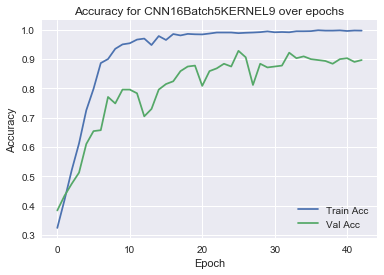

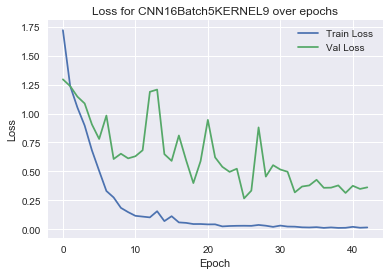

Max val accuracy:  0.9276729552250988
Max train accuracy:  0.9978476108480413


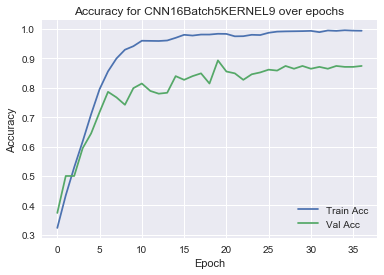

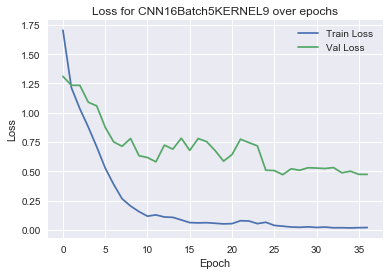

Max val accuracy:  0.8930817613811612
Max train accuracy:  0.9956952216960826


In [11]:
for h in histories:
    checkOutHistory(h)

In [12]:

with open("hist9kernel9s.txt", "w") as f:
    for h in histories:
        f.write(str(h) +"\n")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2200, 6)           0         
_________________________________________________________________
Conv1x500 (Conv1D)           (None, 2200, 32)          1760      
_________________________________________________________________
ReLu00 (Activation)          (None, 2200, 32)          0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 2200, 32)          128       
_________________________________________________________________
Conv1x501 (Conv1D)           (None, 2200, 32)          9248      
_________________________________________________________________
ReLu01 (Activation)          (None, 2200, 32)          0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 2200, 32)          128       
__________